In [1]:
import astropy
from astropy.io import fits 
from astropy.time import Time
from astropy.visualization import time_support
from astropy.timeseries import LombScargle
from astropy.convolution import Box1DKernel
from astropy.convolution import convolve
import matplotlib.pyplot as plt
import astropy.units as u
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import numpy as np
import numpy.ma as ma
import os
import pandas as pd
import scipy.signal as sig
from astropy.stats import sigma_clip
import warnings
import time 

In [2]:
from functools import partial

import matplotlib as mpl
from scipy import signal, stats
from scipy.ndimage import center_of_mass

# install moonbow first. in repo root:
# pip install -e . --no-deps
from moonbow.fit import Fit

rng = np.random.default_rng()

In [3]:
def dataClean(filename): 
    
    """ This function removes nan values and corrects time values for TESS 20 second cadence data. 
        Also corrects TESS flux to energy in ergs."""
    
    #Create an array of time and flux data with nans removed    
    with fits.open(filename, mode="readonly",ignore_missing_simple=True) as hdulist:
        raw_time = hdulist[1].data['TIME']
        raw_flux = hdulist[1].data['PDCSAP_FLUX']
        raw_err = hdulist[1].data['PDCSAP_FLUX_ERR']
    data = np.vstack((raw_time, raw_flux, raw_err))
    nonan_data = data[:, ~np.isnan(data).any(axis=0)]

    times = nonan_data[0]
    flux = nonan_data[1]
    error = nonan_data[2]
    
    #Create Dataframe of cleaned data
    time = np.array(times)
    flux = np.array(flux)
    err = np.array(error)
   

    #Convert energy to ergs
    #dist_cm = distance_pc * 3.086e+18
    #ergs = []
    #ergs_err = []
    
    #for i in flux: 
    #    fluence = i * eff_width
    #    energy = (4 * np.pi * (dist_cm**2) * fluence)
    #    ergs.append(energy*1.95829e-9) #AB system zero point
        
    #for i in err:
    #    fluence_err = i*eff_width
    #    energy_err = (4 * np.pi * (dist_cm**2) * fluence_err)
    #    ergs_err.append(energy_err*1.95829e-9) #AB system zero point
        
    #energy = np.asarray(ergs)
    #error = np.asarray(ergs_err)

    
    #Return cleaned data
    return pd.DataFrame({
                        'Time': time,
                        #'Energy': energy,
                        #'Energy Error': error,
                        'Flux': flux,
                        'Flux Error': err
    })

In [4]:
#Using only until large flare function is completed, need more stars to get a better idea for a good
#model for stellar quiescence generation

def generate_Qcurve(clean_dataframe):
    """ This function takes cleaned data to create a dataframe of the estimated quiescent light curve"""

    q_time = clean_dataframe['Time'] # time associated w/ quiescent flux
    
    #Set and index variables
    fluxes = clean_dataframe['Flux']
    times = clean_dataframe['Time']
    F_err = clean_dataframe['Flux Error'] 

    #Smooth
    smooth_1 = sig.savgol_filter(fluxes,1400,3)
    q_flux = sig.savgol_filter(smooth_1,2000,3)
    
    #Create/return dataframe
    
    return pd.DataFrame({
                'Time': q_time,
                'Quiescent Flux':q_flux
    })


In [5]:
def find_ix_ranges(ix, buffer=False):
    """ Finds indexes in the range.
    
        From MC GALEX function defs"""
    
    foo, bar = [], []
    for n, i in enumerate(ix):
        if len(bar) == 0 or bar[-1] == i-1:
            bar += [i]
        else:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
            bar = [i]
        if n == len(ix)-1:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
    return foo

In [6]:
def get_inff(lc, clipsigma=3, quiet=True, band='NUV',
             binsize=20.):
    """ Calculates the Instantaneous Non-Flare Flux values.
    
        From MC GALEX function defs"""
    
    sclip = sigma_clip(np.array(lc['Flux']), sigma=clipsigma)
    inff = np.ma.median(sclip)
    inff_err = np.sqrt(inff*len(sclip)*binsize)/(len(sclip)*binsize)
    if inff and not quiet:
        print('Quiescent at {m} AB mag.'.format(m=gt.counts2mag(inff, band)))
    return inff, inff_err

In [7]:
def find_flare_ranges(curve,q_curve,sig,quiescence=None):
    """This function will run through the data to find 
    flares and ranges of flares. This function will return
    a table of flares ranges. 
    
    Adapted from MC GALEX function defs.
    Stage: complete"""
    
    tranges = [[min(curve['Time']), max(curve['Time'])]] 
    if not quiescence:
        q, q_err = get_inff(curve)
    else:
        q, q_err = quiescence
    flare_ranges = []
    for trange in tranges:
        ix = np.where(((np.array(curve['Flux'].values)-(sig*np.array(curve['Flux Error'].values)) >= q_curve['Quiescent Flux'])))[0]
        flareFlux = ix
        if not len(ix):
            continue
        flux_ix = []
        
        for ix_range in find_ix_ranges(ix):
            # go backwards
            consec = 0 
            err = curve.iloc[ix_range[0]]['Flux Error'] 
            
            #while flux - err > quiescence, find 2 consecutive points within quiescent curve
            while (curve.iloc[ix_range[0]]['Flux']-err >= q_curve.iloc[ix_range[0]]['Quiescent Flux']) and ix_range[0] > 0 or (consec < 1 and ix_range[0] >0):
                err = curve.iloc[ix_range[0]]['Flux Error']

                if curve.iloc[ix_range[0]]['Flux']- err < q_curve.iloc[ix_range[0]]['Quiescent Flux']:
                    consec +=1
                else: 
                    consec = 0
                if (curve.iloc[ix_range[0]+1]['Time']-curve.iloc[ix_range[0]]['Time']) > 1000: 
                    break               
                ix_range = [ix_range[0] - 1] + ix_range
                
                # go forwards
            consec = 0 
            err = curve.iloc[ix_range[-1]]['Flux Error']
            while(curve.iloc[ix_range[-1]]['Flux'] - err >= q_curve.iloc[ix_range[-1]]['Quiescent Flux']) and ix_range[-1] != len(curve)-1 or (consec <1 and ix_range[:-1]!= len(curve)-1):
                err = curve.iloc[ix_range[-1]]['Flux Error']
                if curve.iloc[ix_range[-1]]['Flux']-err < q_curve.iloc[ix_range[-1]]['Quiescent Flux']:
                    consec += 1
                else: 
                    consec = 0
                if curve.iloc[ix_range[0]]['Time']-curve.iloc[ix_range[-1]]['Time'] > 1000: 
                    break
                ix_range = ix_range + [ix_range[-1] + 1]
                
            flux_ix += ix_range
        ix = np.unique(flux_ix)
        flare_ranges += find_ix_ranges(list(np.array(ix).flatten()))
    return(flare_ranges,flareFlux)


In [8]:
def refine_flare_ranges(curve,q_curve, sig=3., flare_ranges=None):
    """ Identify the start and stop indexes of a flare event after
    refining the INFF by masking out the initial flare detection indexes. 
    From MC GALEX function defs."""
    time_support()
    if not flare_ranges:
        flare_ranges, _ = find_flare_ranges(curve, q_curve, sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    quiescience_mask = [False if i in flare_ix else True for i in
                        np.arange(len(curve['Time']))]
    quiescence = q_curve
    quiescence_err = (np.sqrt(curve['Flux'][quiescience_mask].sum())/curve['Flux'].sum())
    flare_ranges, flare_3sigs = find_flare_ranges(curve,q_curve,
                                                  quiescence=(quiescence,
                                                              quiescence_err),
                                                  sig=sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    not_flare_ix = list(set([x for x in range(len(curve['Time']))]) - set(flare_ix))
      
    return flare_ranges, flare_ix

In [9]:
def qpp_find(flaring_frame,ranges_ix,energy_ix):
    
    ranges = []
    for i,v in enumerate(ranges_ix):
        t = flaring_frame['Time'][v]
        f = flaring_frame['Flux'][v]
        ranges.append([i,t,f])

        #Select Large Flares

    large_flares = []
    for i,v in enumerate(ranges_ix):
        if len(v)>=45:                    #~15 minute minimum                    
            large_flares.append((v))
        else:
            continue

#Match Data to Large Flares

    large_flare_data = []
    for i,v in enumerate(large_flares):
        data = flaring_frame['Energy'][large_flares[i]]
        large_flare_data.append(data)
    
    norm_flares=[] #normalize flare values
    for i in range(len(large_flare_data)):
        mx = max(large_flare_data[i])
        norm_flares.append(large_flare_data[i]/mx)
    
    times=[]
    for i in range(len(large_flares)):
        t = flaring_frame['Time'][large_flare_data[i].index]
        times.append(t)
        
    lg_flare_data=[]
    lg_flare_time=[]
    lg_flare_det=[]
    lg_flare_params = []
    flare_fits = []

    for i in range(len(large_flares)):
        model = aflare2
        x = flaring_frame['Time'][large_flares[i]]
        y = norm_flares[i]
        data = pd.DataFrame({'time': x, 'energy': y})
    
        rise = x[0:np.argmax(y)].values
        fwhm = (max(rise)-min(rise))*2
    
        fitter = Fit(
        underlying_function=model,
        dimensionality=1,
        data=data,
        dependent_variable='energy')
    
        fitter.make_vector(independent_variables=['time'])
        fitter.fit(guess=np.array((max(rise),fwhm,1,
                              1.00000, 1.94053, -0.175084, -2.3769, -1.12498,
                              0.689008, -1.600536, 0.302963, -0.278318))) 
        if fitter.det > 0.70:
            lg_flare_time.append(x)
            lg_flare_data.append(y)
            lg_flare_det.append(fitter.det)
            fit_params, covariance_matrix = fitter.curve_fit
            lg_flare_params.append((fit_params))
            fit = fitter.fitted_curve 
            flare_fits.append((fit))
    return lg_flare_data, lg_flare_time, lg_flare_det, lg_flare_params, flare_fits

In [10]:
def fit_residuals(lg_flare_data,flare_fits):
    residuals = []
    for i in range(len(lg_flare_data)):
        res_i = lg_flare_data[i]-flare_fits[i]
        residuals.append((res_i))

    kernel = Box1DKernel(8)
    res_fits = []
    for i in range(len(residuals)):
        res_fit = sig.savgol_filter(residuals[i],21,3)
        fit2 = convolve(res_fit,kernel,boundary='extend')
        res_fits.append(fit2)
    
    return(residuals, res_fits)


#to view/plot residual fits: 
    
#fig,ax = plt.subplots((len(lg_flare_data)))
#for i in range(len(res_fits)):
#    ax.flat[i].plot(range(len(residuals[i])),residuals[i],c='grey')
#    ax.flat[i].plot(range(len(res_fits[i])),res_fits[i],c='black')

In [11]:
def energyCalculation2(flaring_frame,q_frame,flare_ranges,binsize=20):
    """This function will calculate the energies of each flare.
        Stage: complete"""

    distance_cm = 35*3.086e+18
    eff_width = 3.898e-5 
    flare_flux = flaring_frame['Energy'][flare_ranges[1]]-q_frame['Quiescent Energy'][flare_ranges[1]]
    flare_flux_error = flaring_frame['Energy Error'][flare_ranges[1]]
    
    
    energy_error=[]
    energies=[]
    flare_flux[flare_flux<0]=0
    
    for i,v in enumerate(flare_ranges[0]):
        integrated_flux = (flare_flux[v]*binsize).sum()
        fluence_error = np.sqrt(((flare_flux_error[v]*binsize)**2).sum())*eff_width
        fluence = integrated_flux*eff_width
        energy = (4 * np.pi * (distance_cm**2) * fluence)
        energy_err = (4 * np.pi * (distance_cm**2) * fluence_error)
        energy_error.append(energy_err*1.95829e-9 )
        energies.append(energy*1.95829e-9) 
        
    #Using AB system zero point (1.95829e-9 erg/cm2/s/A) from 
    #http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=TESS/TESS.Red&&mode=browse&gname=TESS&gname2=TESS
    
    return(energies,energy_error)

In [12]:
def FlareTable(flaring_frame,flare_ranges):#,energies):
    """This function will build a table of all flares.
        Stage: complete"""
    #Define variables
    times = flaring_frame['Time']
    energy = energies[0]
    energy_error = energies[1]
    
    #find peaks
    peak_energy = np.argmax(energy)
    peak_time = times(np.where(np.argmax(energy)))
    duration = []
    
    for flare in flare_ranges[0]:
        start_ix = times[flare[0]]
        stop_ix = times[flare[-1]]
        duration.append(((times[flare[-1]]-times[flare[0]])).sec)
    
    #Build flare table
    flareTable = pd.DataFrame({
                                "Peak Time": peak_time,
                                "Peak Energy": peak_energy,
                                "Duration (s)": duration,
                                "Total Energy": energy,
                                "Energy Error": energy_error
    })
    
    return(flareTable)
        

In [13]:
def aflare2(t, tpeak, fwhm, ampl,
            c0,c1,c2,c3,c4,
            d0,d1,d2,d3):
#    t : 1-d array
#        The time array to evaluate the flare over
#    tpeak : float
#        The time of the flare peak
#    fwhm : float
#        The "Full Width at Half Maximum", timescale of the flare
#   ampl : float
#        The amplitude of the flare
#    Returns
#    flare : 1-d array
#        The flux of the flare model evaluated at each time
    #_fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fr = [c0,c1,c2,c3,c4]
    #_fd = [0.689008, -1.60053, 0.302963, -0.278318]
    _fd = [d0,d1,d2,d3]
    
    t = np.array(t)
    flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                (t > tpeak)],
                            [lambda x: (_fr[0]+                       # 0th order
                                        _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                        _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                        _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                        _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                             lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                        _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                            ) * np.abs(ampl) # amplitude

    return flare

### Af Psc Analysis

In [14]:
#rawdata = '/Users/katborski/Documents/GitHub/AFPSC/TESS/tess2021232031932-s0042-0000000250081915-0213-a_fast-lc.fits'
#flaring_frame = dataClean(rawdata,35,3.898e-5) #35=dist in pc, 3.898e-5=eff width for Af Psc
#q_frame = generate_Qcurve(flaring_frame)

In [15]:
#ranges_ix,energy_ix = find_flare_ranges(flaring_frame, q_frame, 3,35, quiescence=None)

In [16]:
#qpps = qpp_find(flaring_frame, ranges_ix, energy_ix)

In [17]:
#res_fit = fit_residuals(qpps[0],qpps[4])

In [18]:
###to view/plot davenport fit: 

#fig,ax = plt.subplots((len(lg_flare_data)))
#for i in range(len(lg_flare_data)):    
#    ax.flat[i].plot(lg_flare_time[i],lg_flare_data[i])
#    ax.flat[i].plot(lg_flare_time[i],fits_[i],c='black')
#    ax.flat[i].set_title(lg_flare_det[i])
#    plt.setp(ax, xticks=[]) 

In [19]:
###to view/plot residual fits: 
    
#fig,ax = plt.subplots((len(lg_flare_data)))
#for i in range(len(res_fits)):
#    ax.flat[i].plot(range(len(residuals[i])),residuals[i],c='grey')
#    ax.flat[i].plot(range(len(res_fits[i])),res_fits[i],c='black')

### Test Analysis w/ EV Lac

In [20]:
#test_rawdata = '/Users/katborski/Documents/GitHub/QPPs/moonbow-main/tess2022244194134-s0056-0000000154101678-0243-a_fast-lc.fits'
#test_flaring_frame = dataClean(test_rawdata,5.05,3.898e-5) #5.05=dist in pc to EV Lac, 3.898e-5=eff width for TESS
#test_q_frame = generate_Qcurve(test_flaring_frame)


In [21]:
#test_ranges_ix,test_energy_ix = find_flare_ranges(test_flaring_frame,test_q_frame,4,5.05,quiescence=None)

In [22]:
#test_qpps = qpp_find(test_flaring_frame, test_ranges_ix, test_energy_ix)

In [23]:
#test_res_fit = fit_residuals(test_qpps[0],test_qpps[4])

In [24]:
###to view/plot davenport fit: 

#fig,ax = plt.subplots((len(test_qpps[0])))
#for i in range(len(test_qpps[0])):    
#    ax.flat[i].plot(test_qpps[1][i],test_qpps[0][i])
#    ax.flat[i].plot(test_qpps[1][i],test_qpps[4][i],c='black')
#    ax.flat[i].set_title(test_qpps[2][i])
#    plt.setp(ax, xticks=[]) 
#plt.show()

In [25]:
###to view/plot residual fits: 
    
#fig,ax = plt.subplots((len(test_res_fit[0])))
#for i in range(len(test_res_fit[0])):
#    ax.flat[i].plot(range(len(test_res_fit[0][i])),test_res_fit[0][i],c='grey')
#    ax.flat[i].plot(range(len(test_res_fit[1][i])),test_res_fit[1][i],c='black')
#plt.show()

In [26]:
#ALL WORKING, uncomment singular '#' lines to run.

In [27]:
### CROSSMATCH DATA W/ GAIA ###
warnings.filterwarnings('ignore')

In [28]:
dataset = pd.read_csv('/Users/katborski/Documents/GitHub/QPPs/GI_targets_20s_S038_v1-2.csv')

In [29]:
skypos = []
for i in range(len(dataset)):
    ra = dataset['RA'][i]
    dec = dataset['Dec'][i]
    skypos.append((ra,dec))

In [30]:
#dataset

In [31]:
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"

In [32]:
def angularSeparation(ra1, dec1, ra2, dec2):
    d2r = np.pi/180.
    ra2deg = 1./d2r
    d1 = dec1*d2r,
    d2 = dec2*d2r
    r1 = ra1*d2r
    r2 = ra2*d2r
    a = np.sin((d2-d1)/2.)**2.+np.cos(d1)*np.cos(d2)*np.sin((r2-r1)/2.)**2.
    r = 2*np.arcsin(np.sqrt(a))
    return r*ra2deg

In [33]:
# define the search box
width = u.Quantity(0.05, u.deg)
height = u.Quantity(0.05, u.deg)

rs = []
for i in range(len(skypos)):
    query_success=0
    while query_success==0:
        #print(ra[i],dec[i])
        try:
            r = Gaia.query_object_async(coordinate=coord.SkyCoord(ra=skypos[i][0], dec=skypos[i][1], unit=(u.degree, u.degree),
                                                          frame='icrs'), width=width, height=height)
            rs.append(r)
            query_success=1
        except TimeoutError:
            pass

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


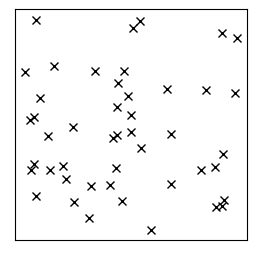

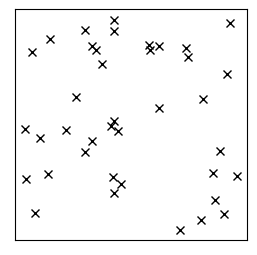

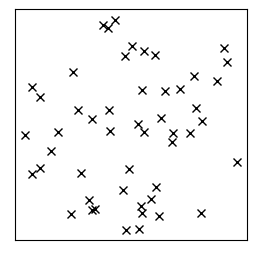

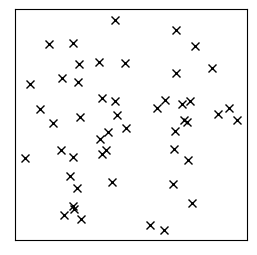

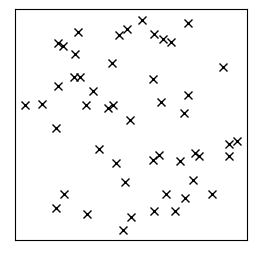

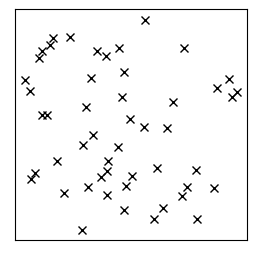

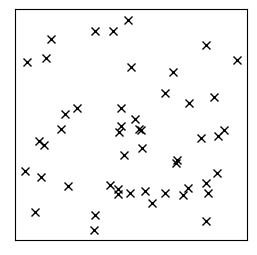

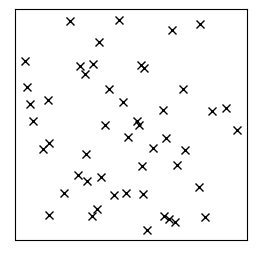

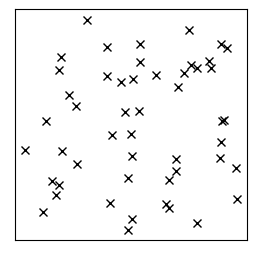

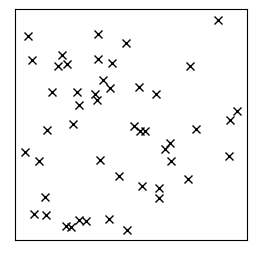

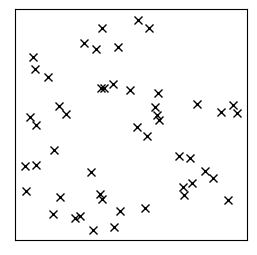

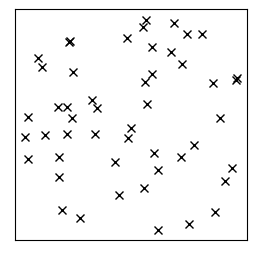

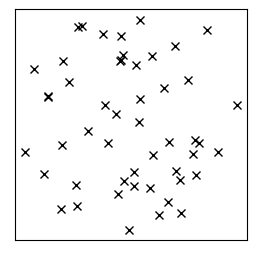

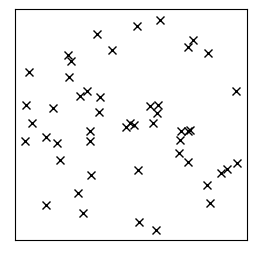

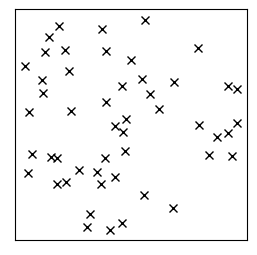

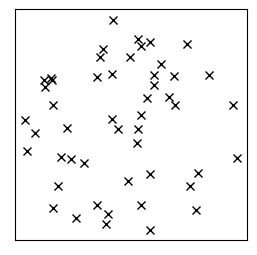

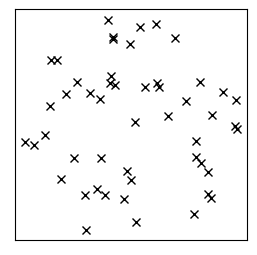

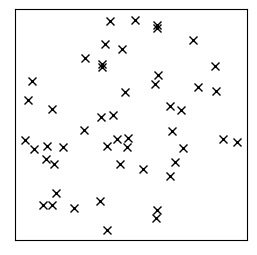

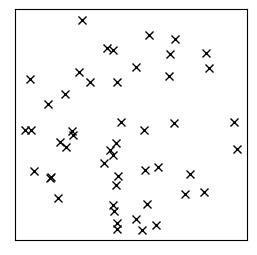

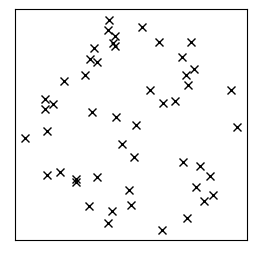

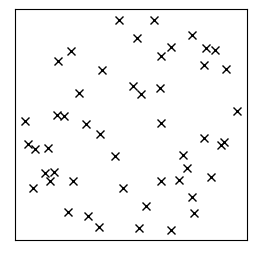

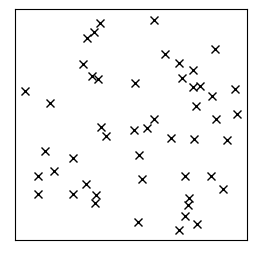

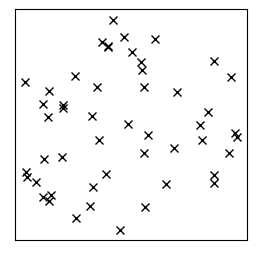

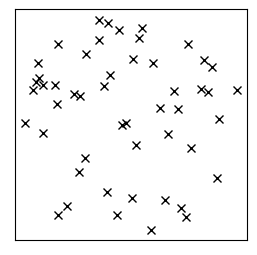

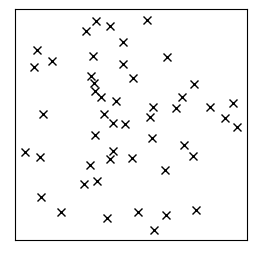

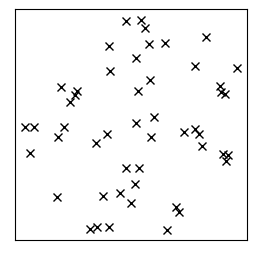

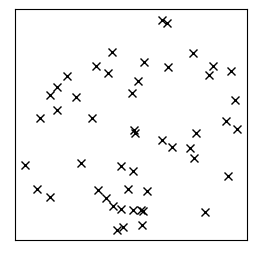

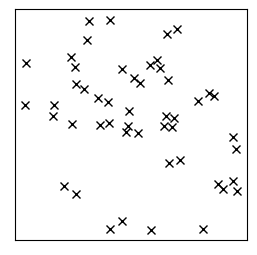

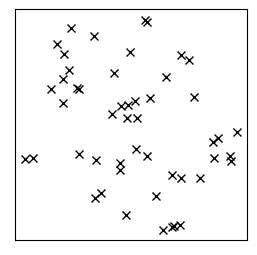

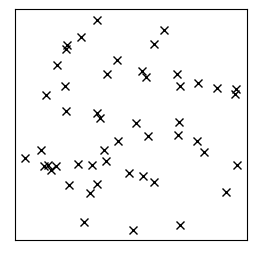

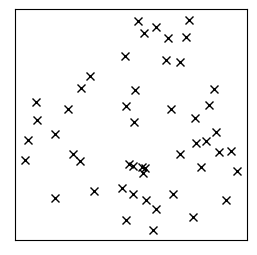

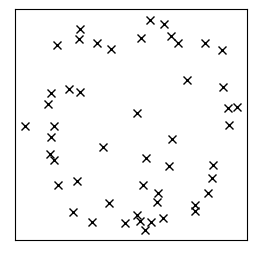

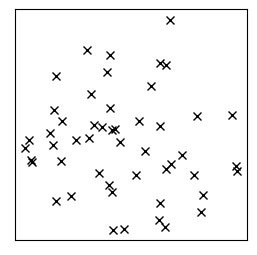

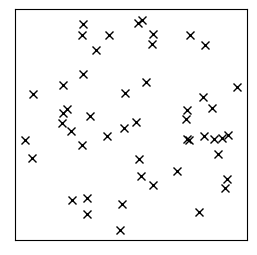

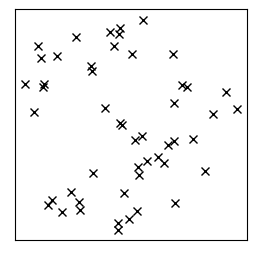

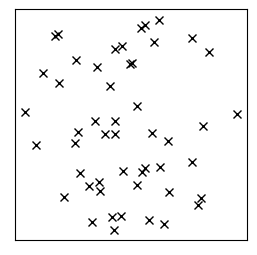

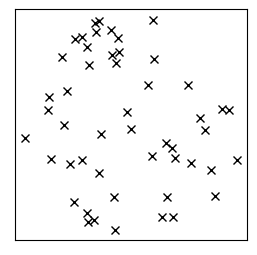

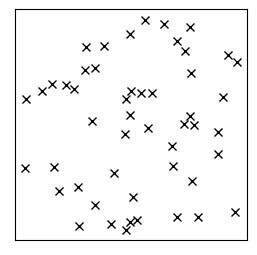

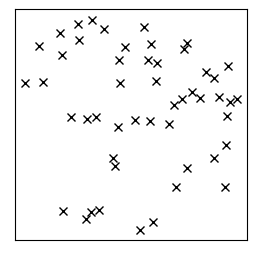

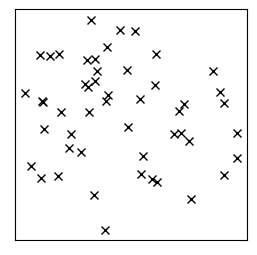

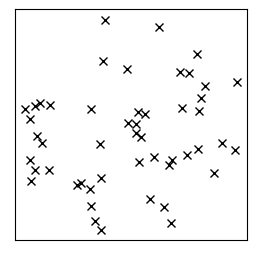

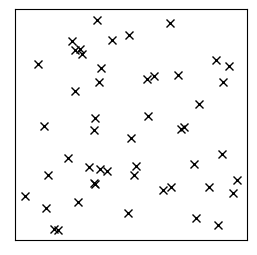

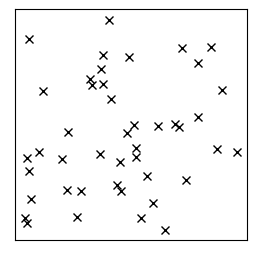

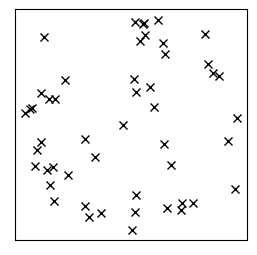

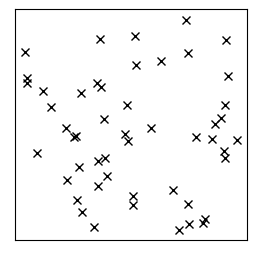

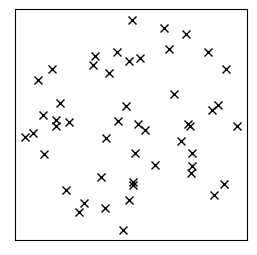

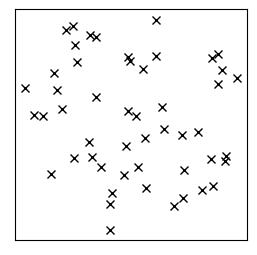

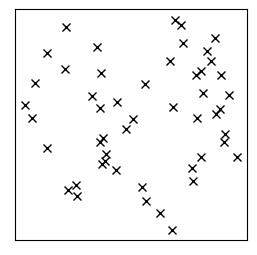

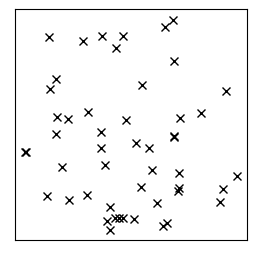

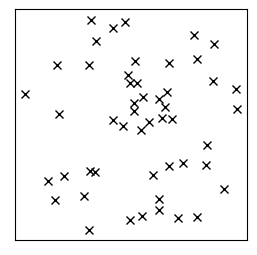

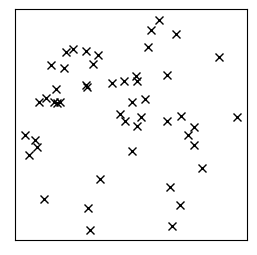

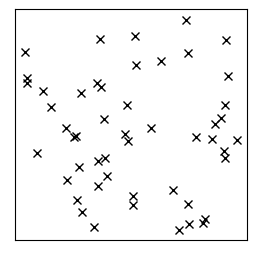

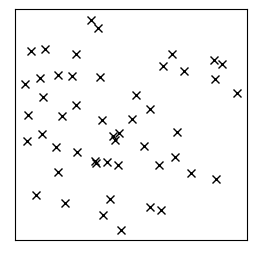

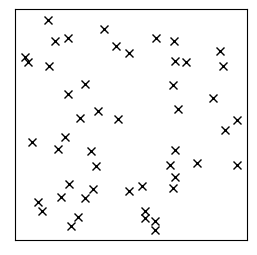

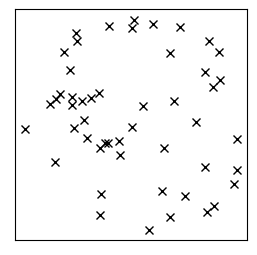

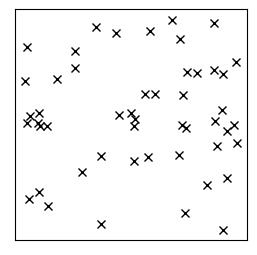

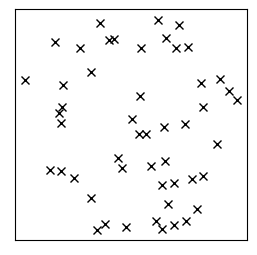

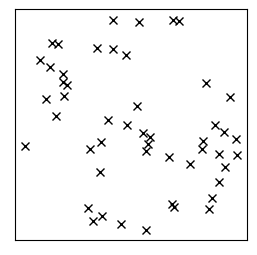

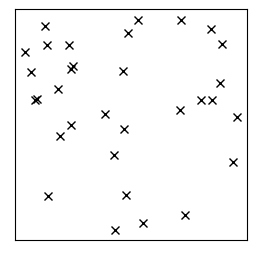

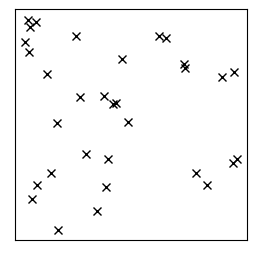

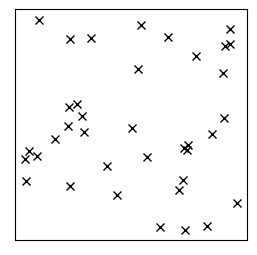

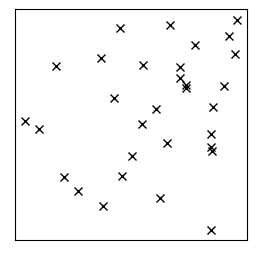

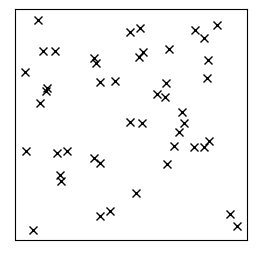

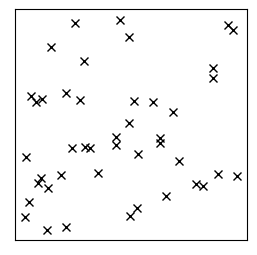

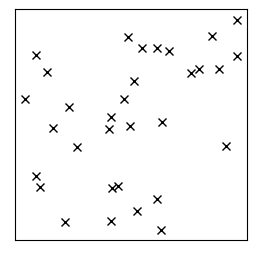

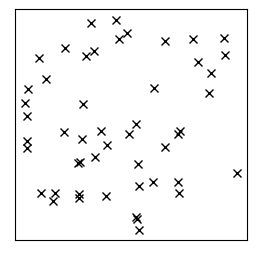

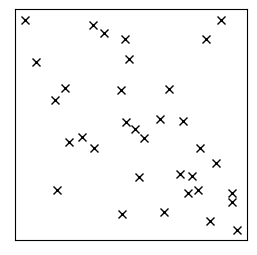

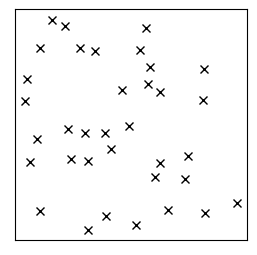

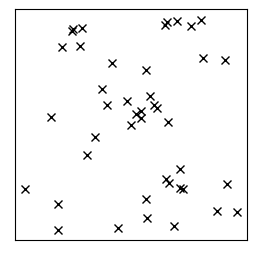

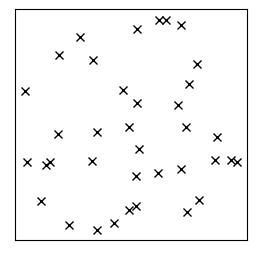

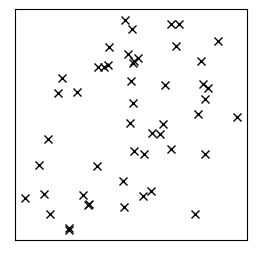

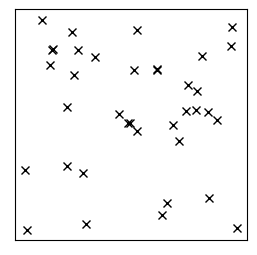

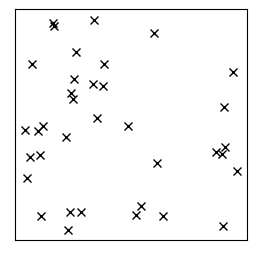

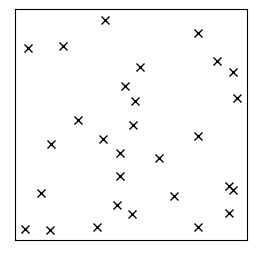

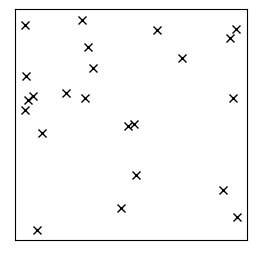

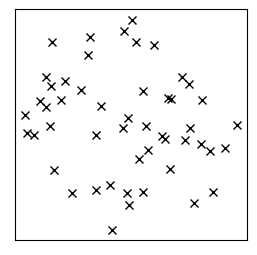

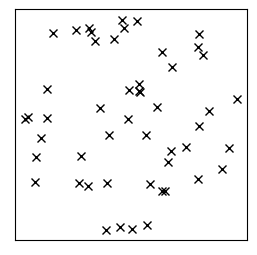

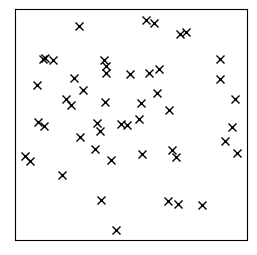

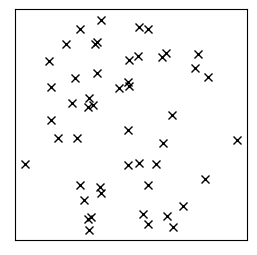

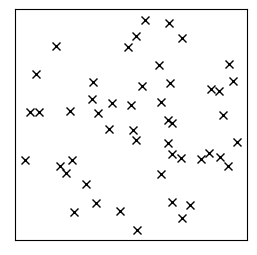

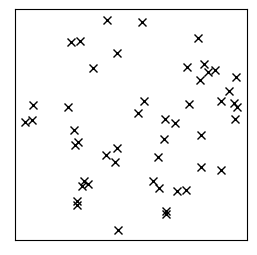

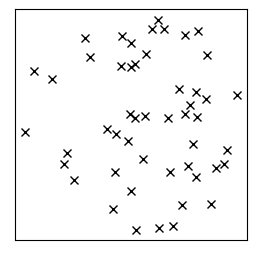

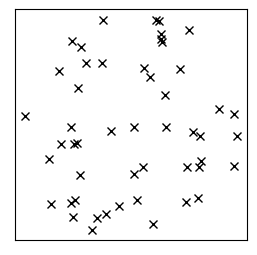

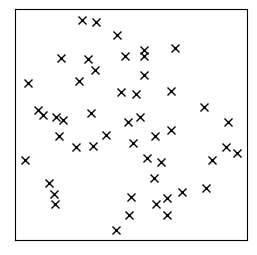

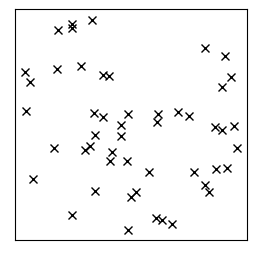

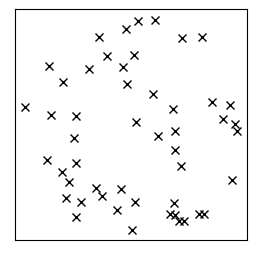

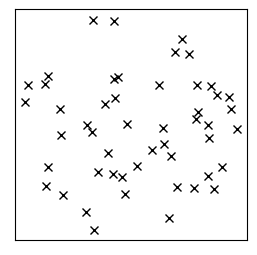

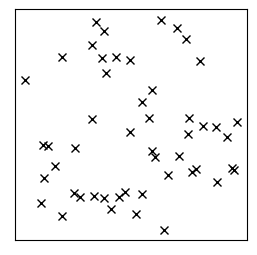

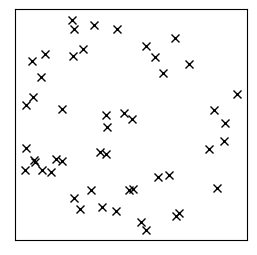

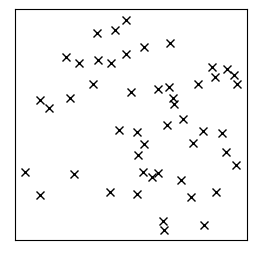

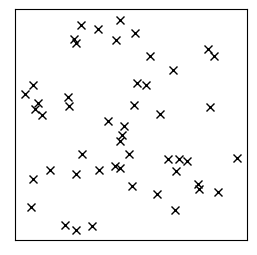

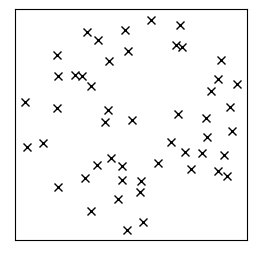

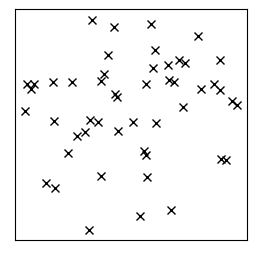

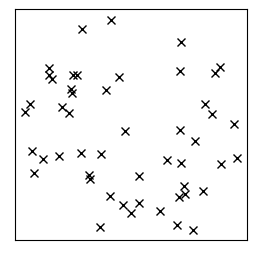

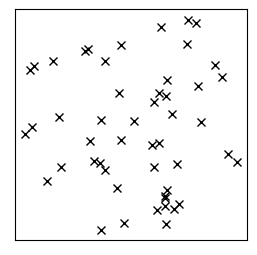

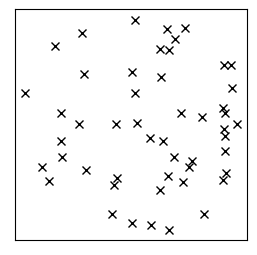

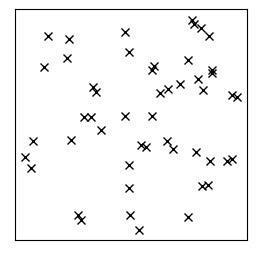

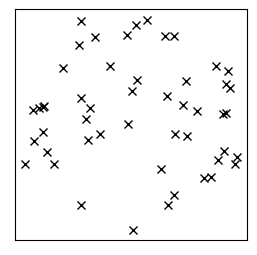

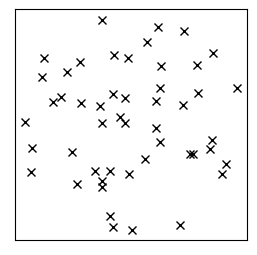

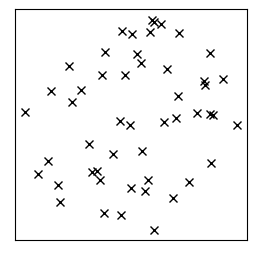

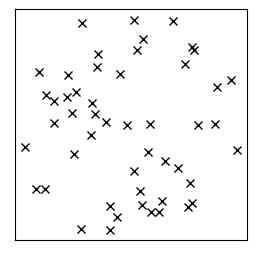

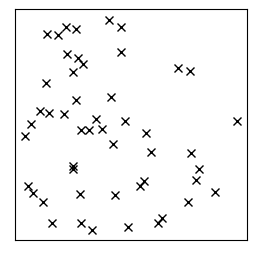

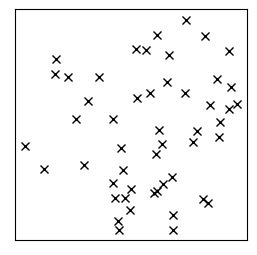

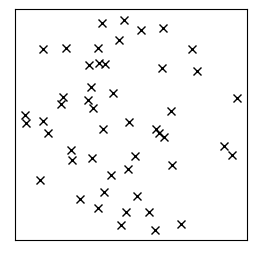

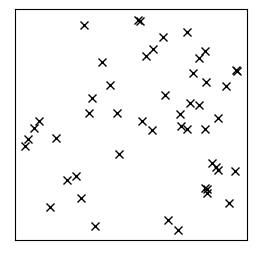

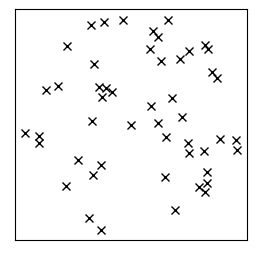

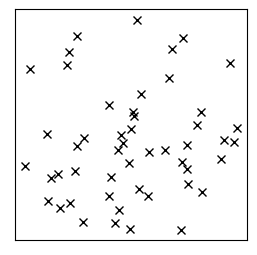

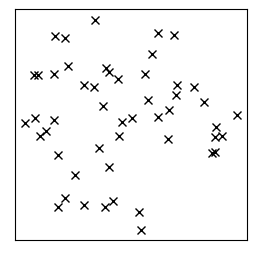

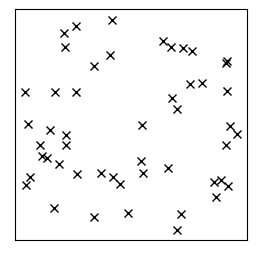

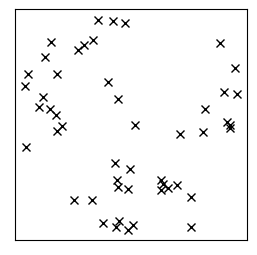

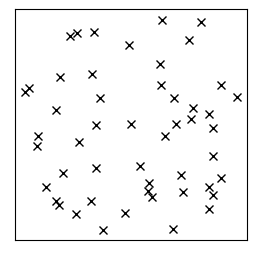

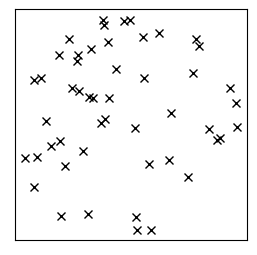

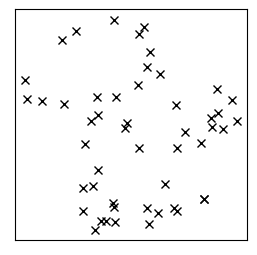

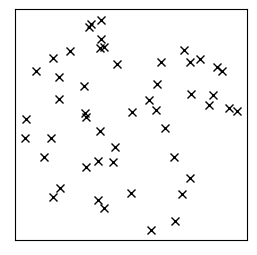

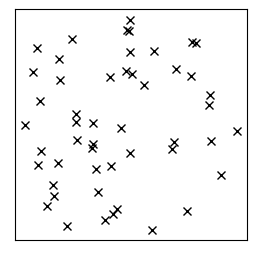

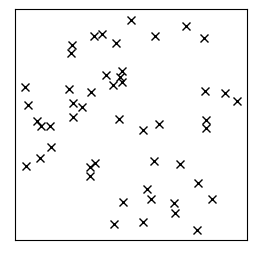

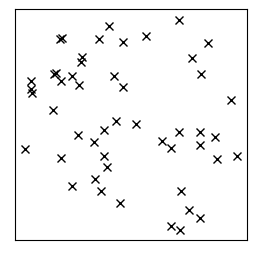

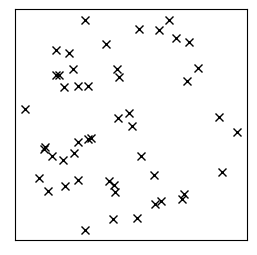

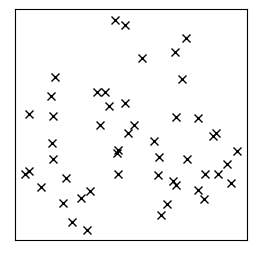

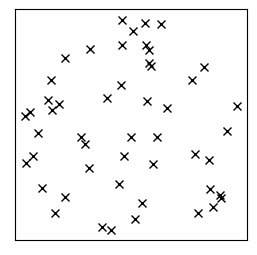

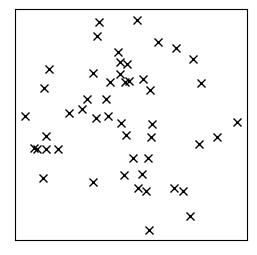

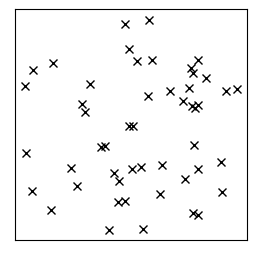

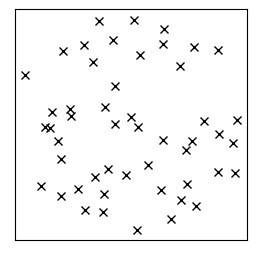

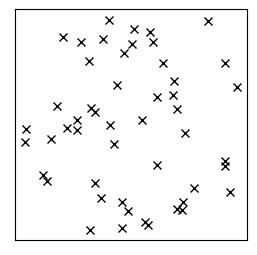

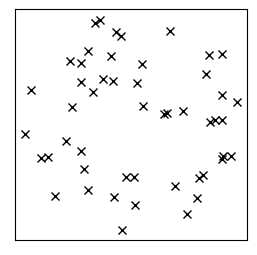

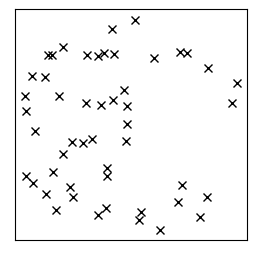

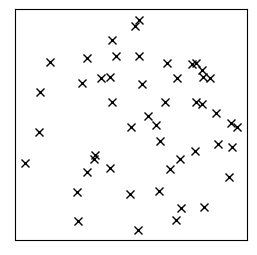

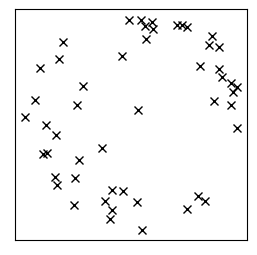

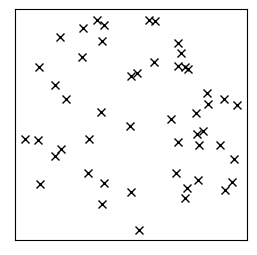

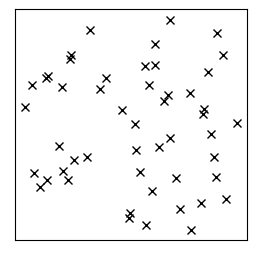

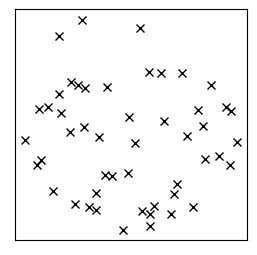

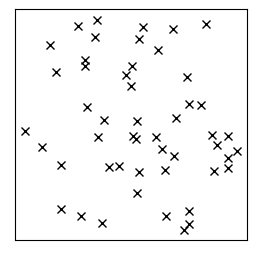

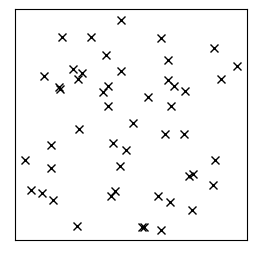

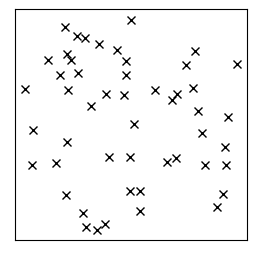

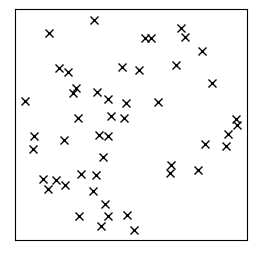

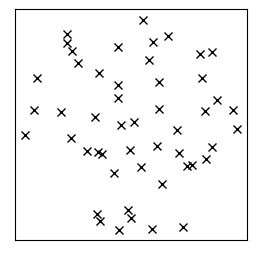

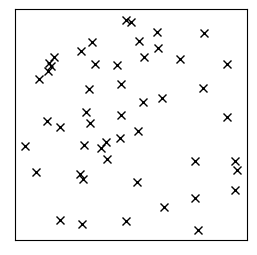

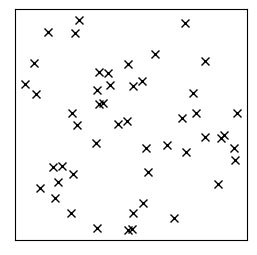

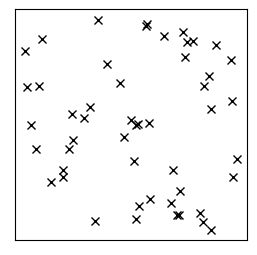

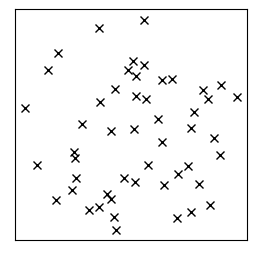

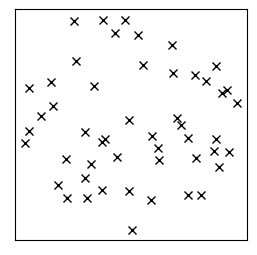

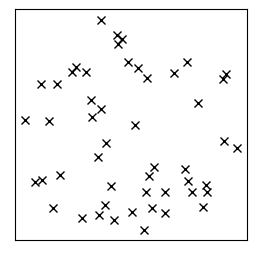

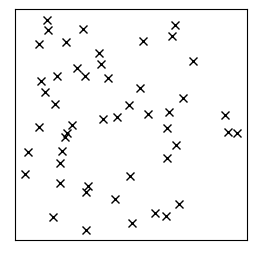

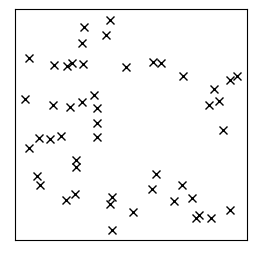

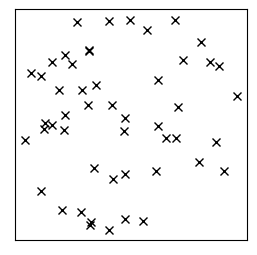

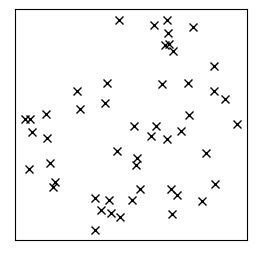

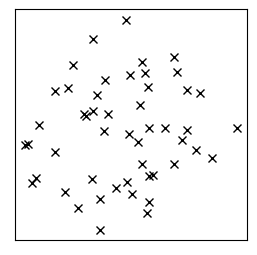

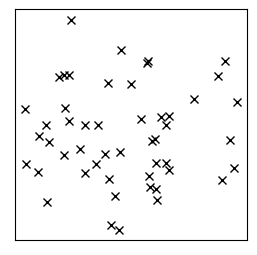

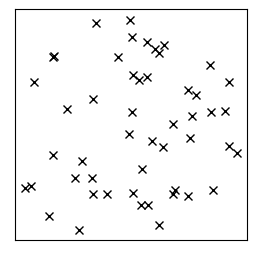

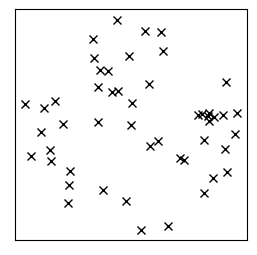

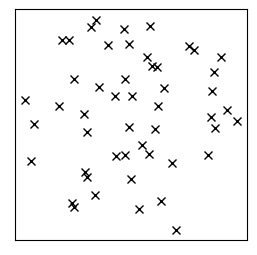

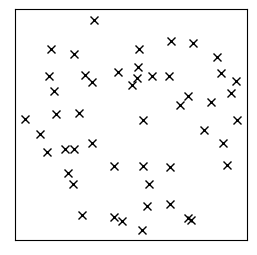

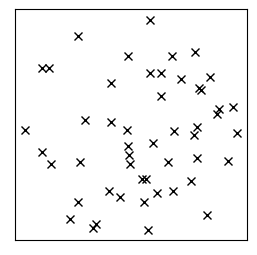

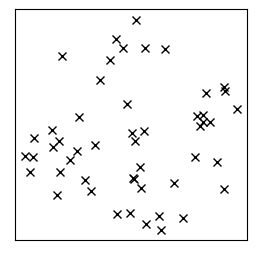

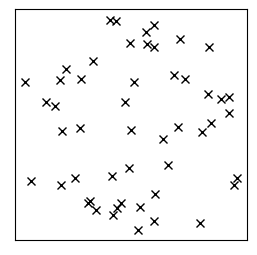

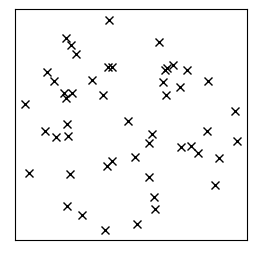

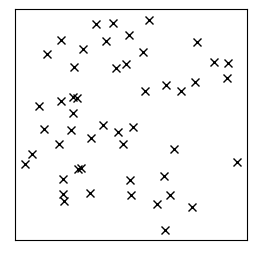

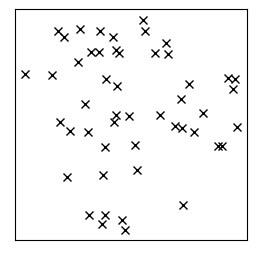

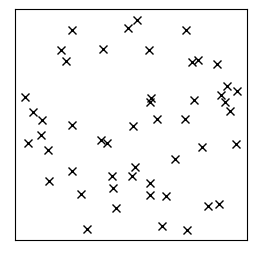

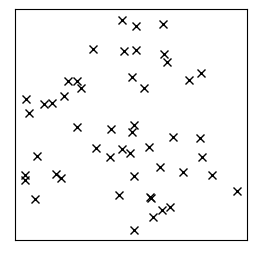

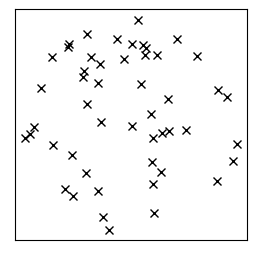

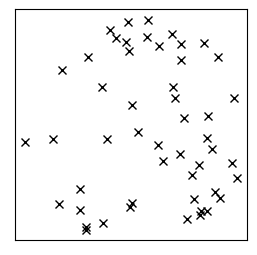

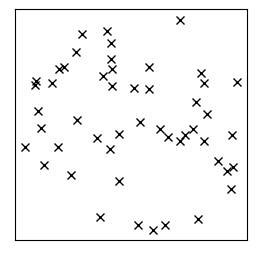

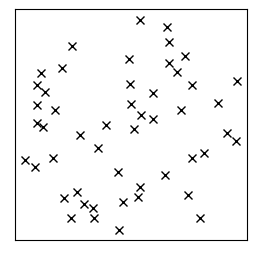

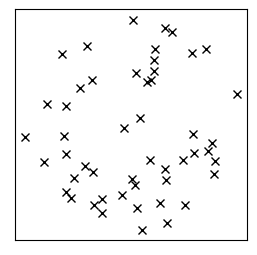

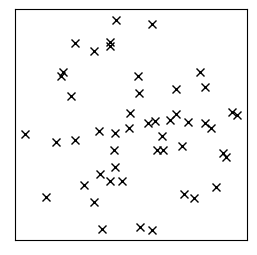

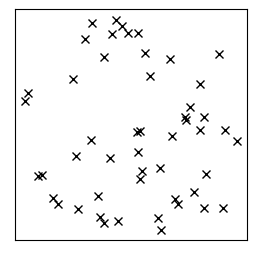

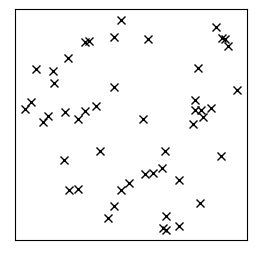

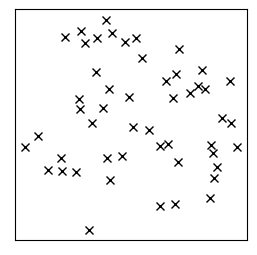

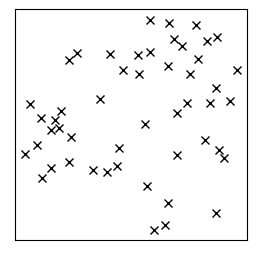

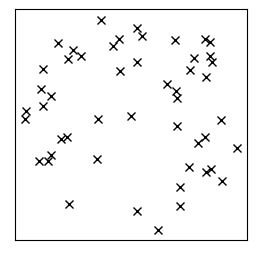

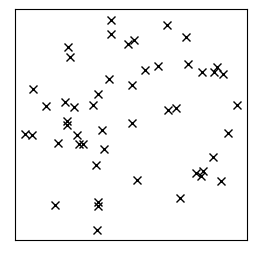

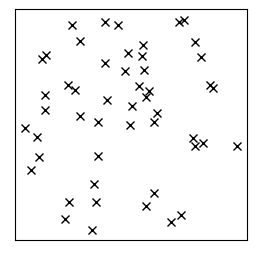

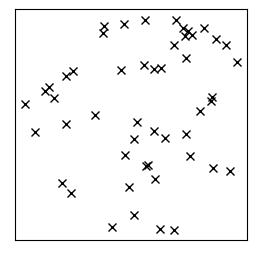

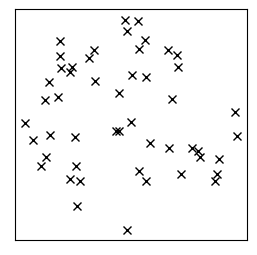

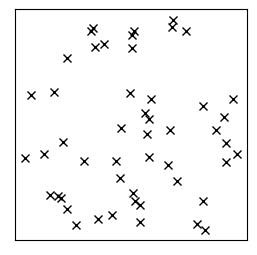

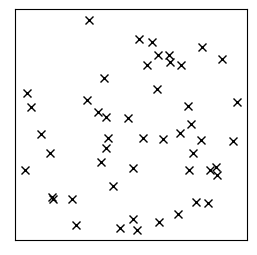

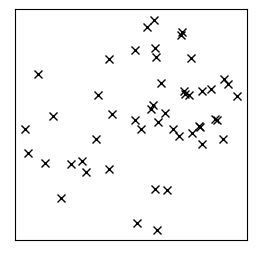

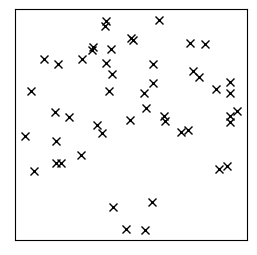

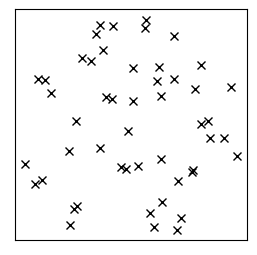

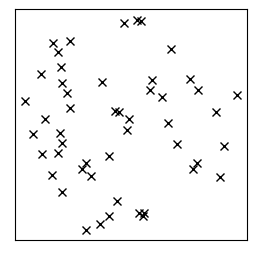

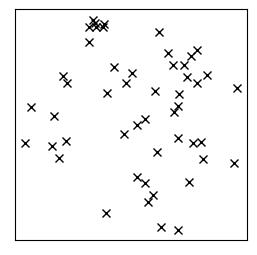

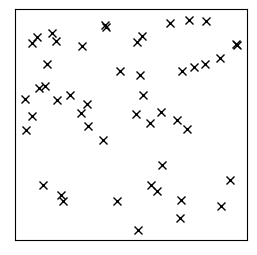

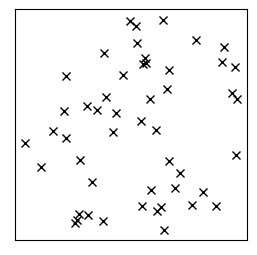

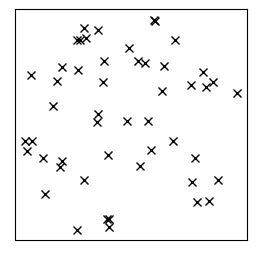

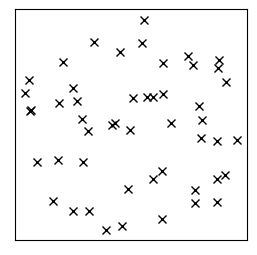

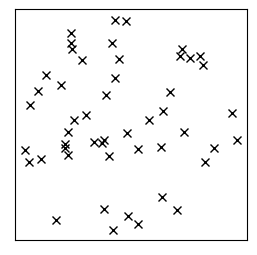

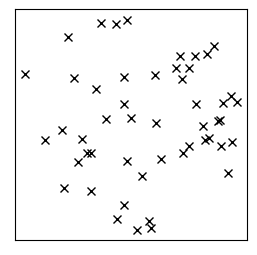

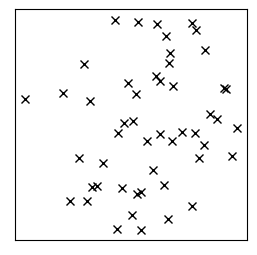

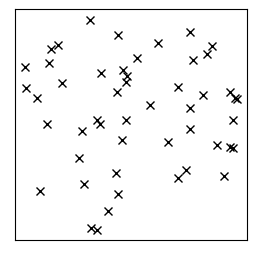

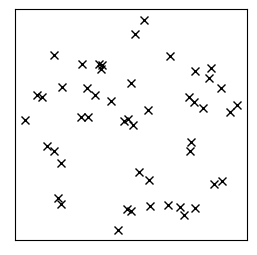

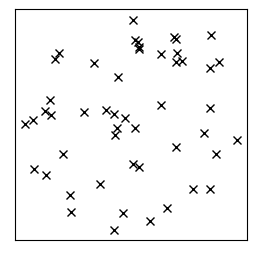

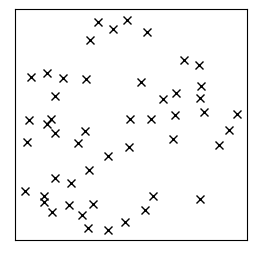

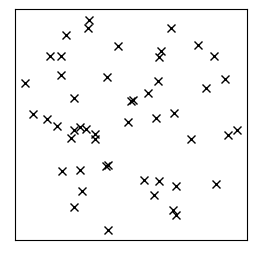

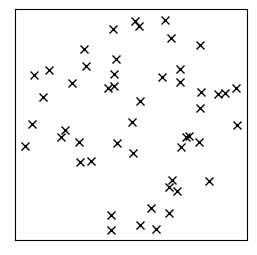

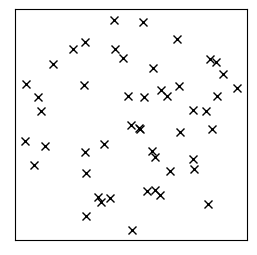

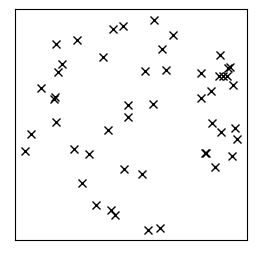

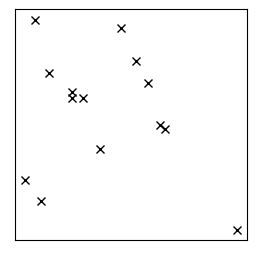

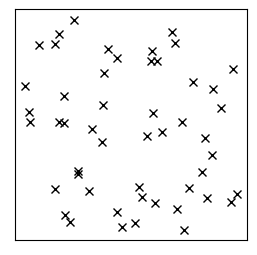

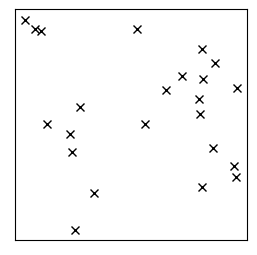

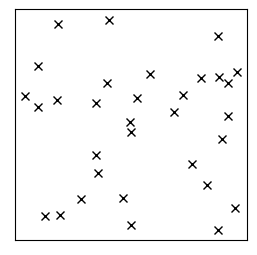

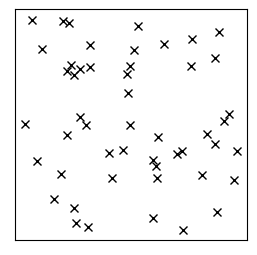

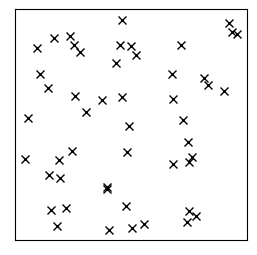

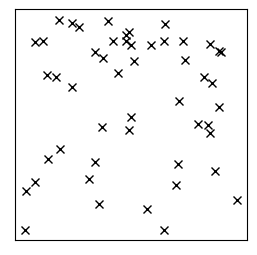

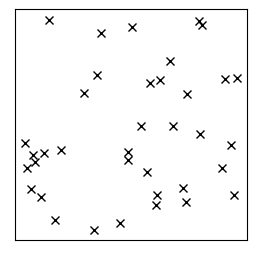

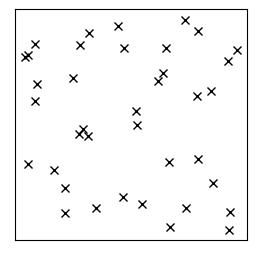

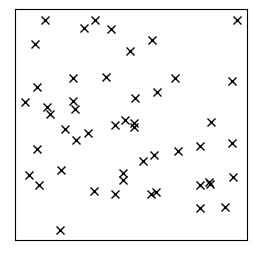

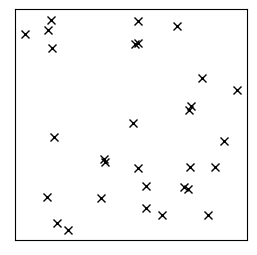

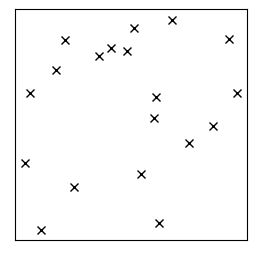

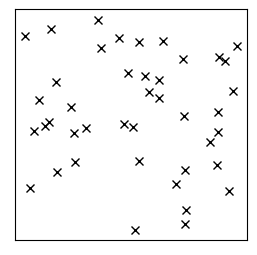

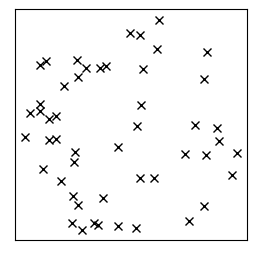

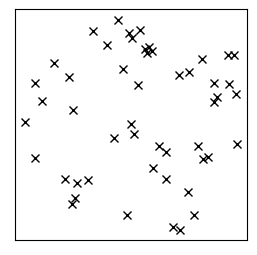

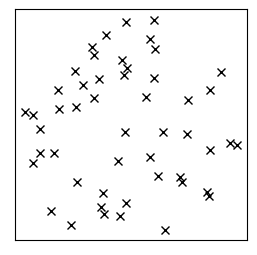

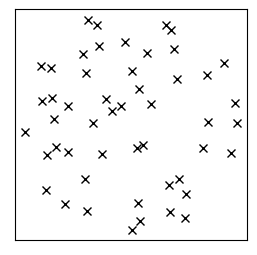

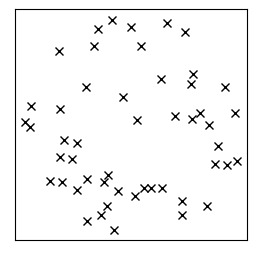

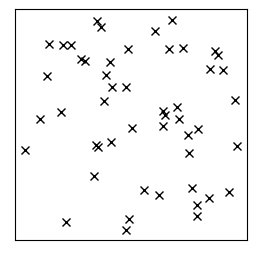

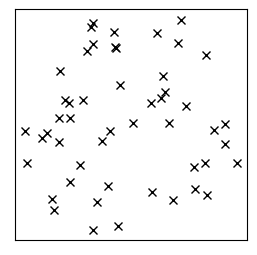

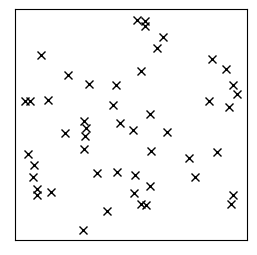

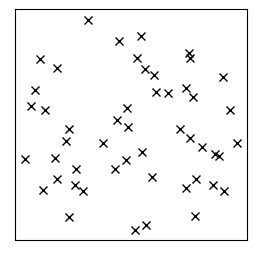

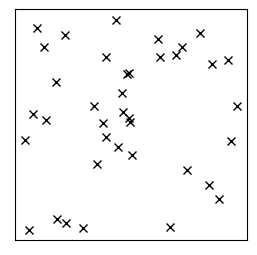

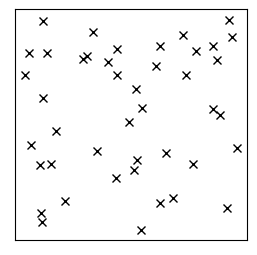

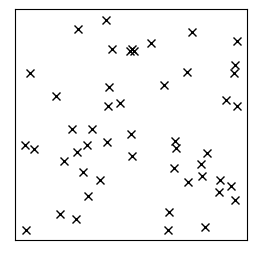

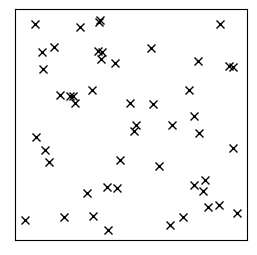

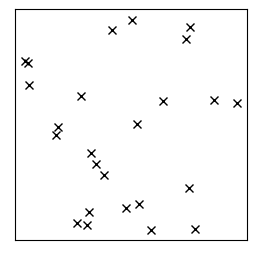

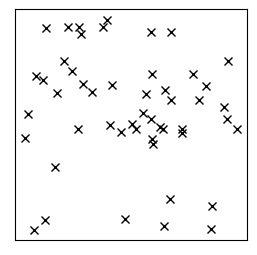

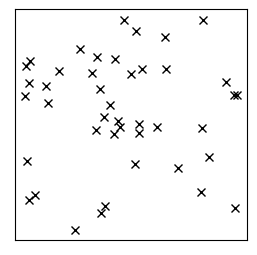

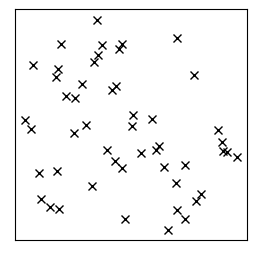

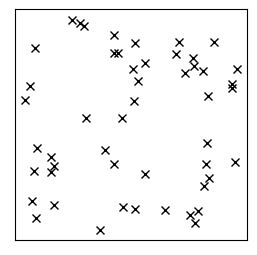

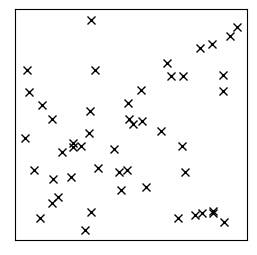

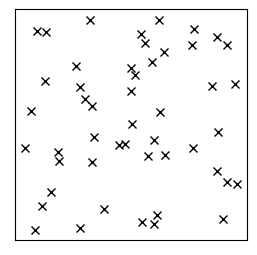

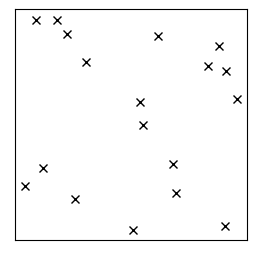

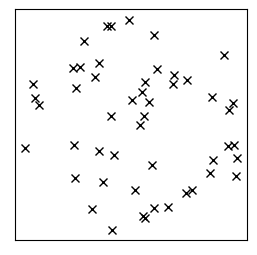

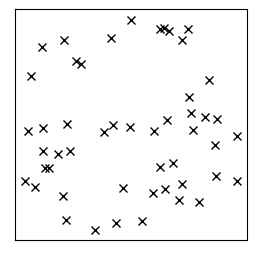

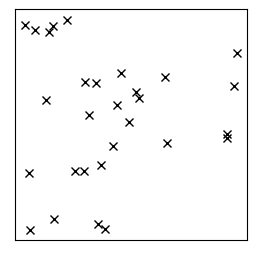

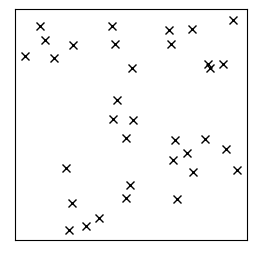

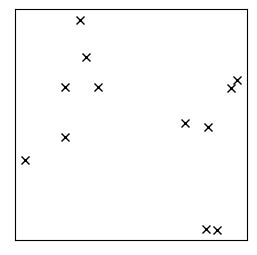

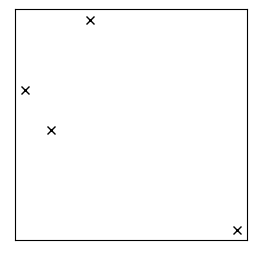

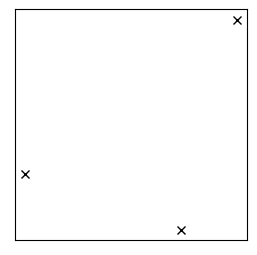

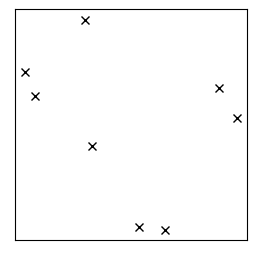

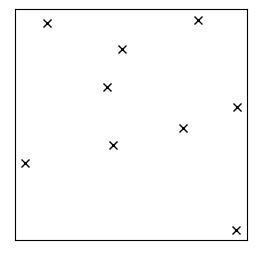

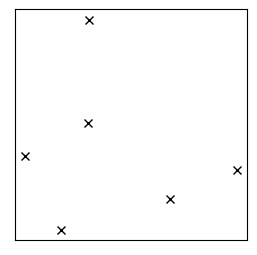

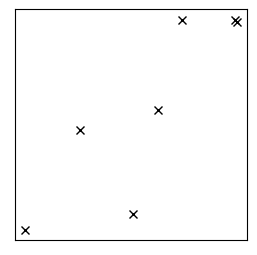

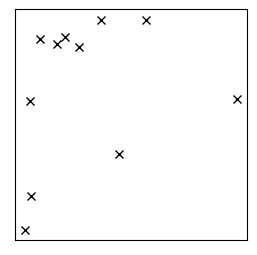

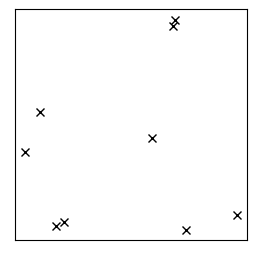

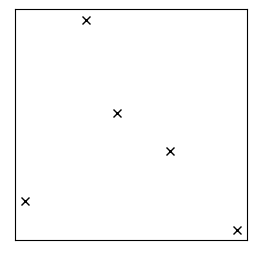

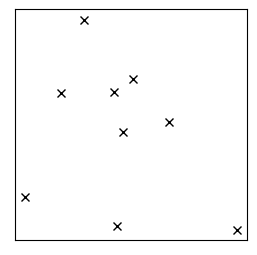

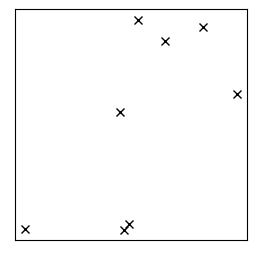

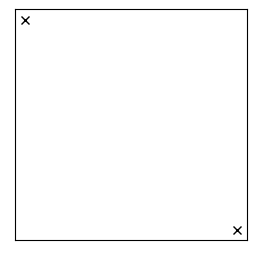

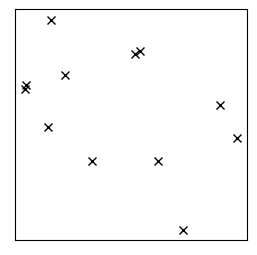

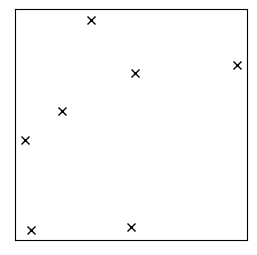

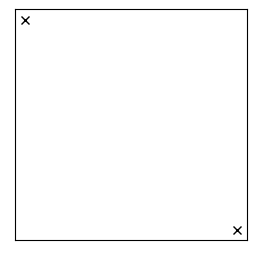

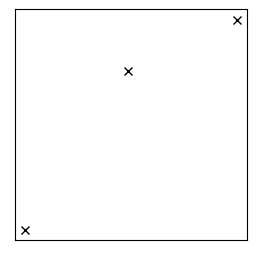

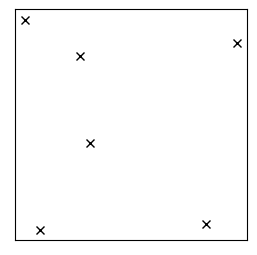

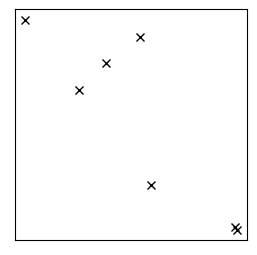

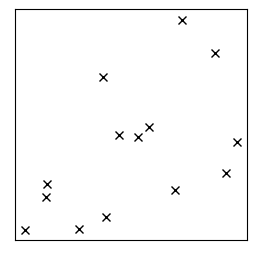

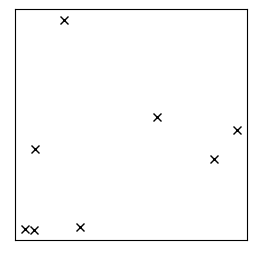

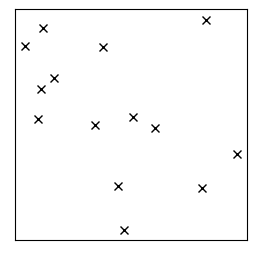

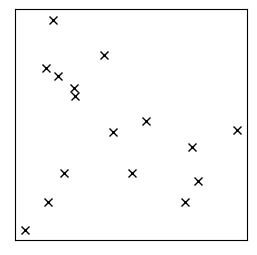

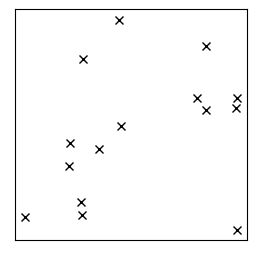

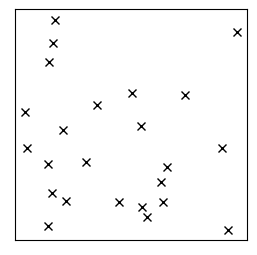

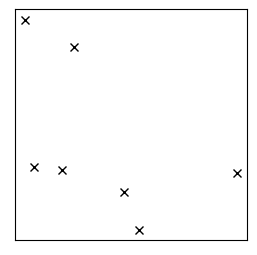

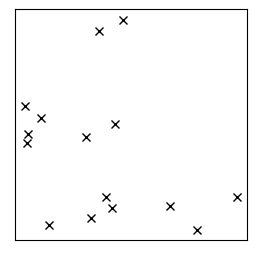

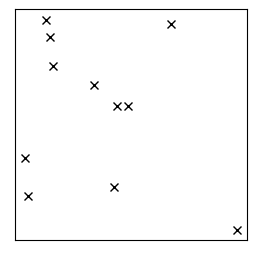

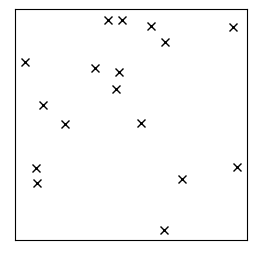

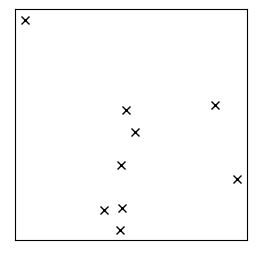

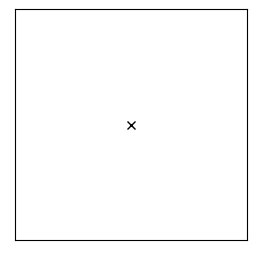

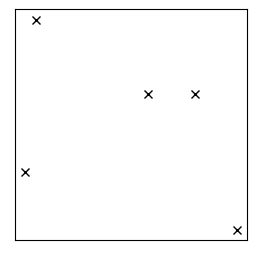

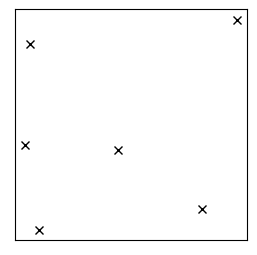

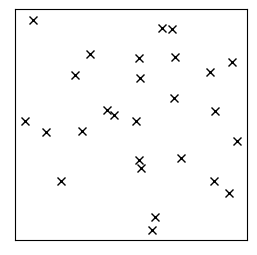

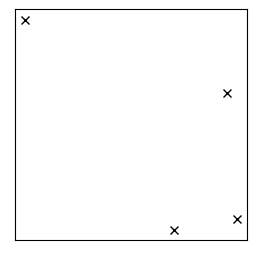

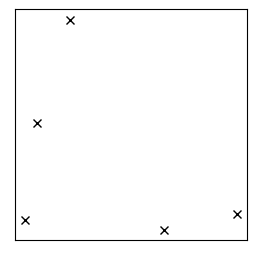

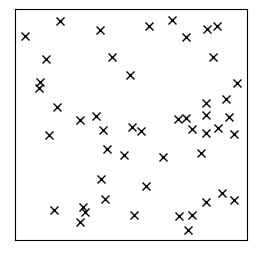

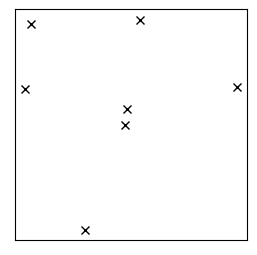

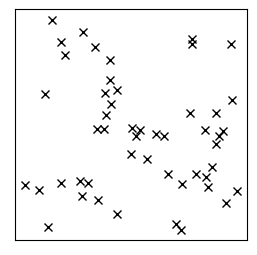

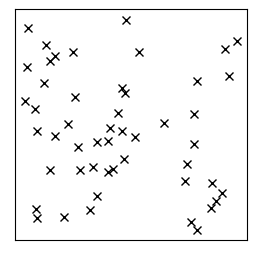

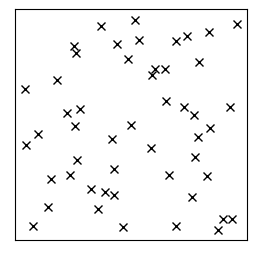

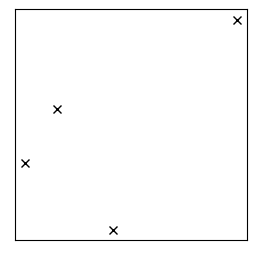

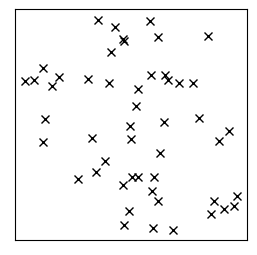

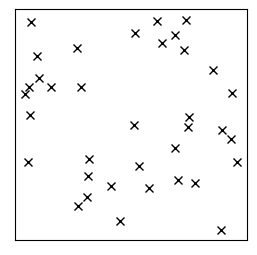

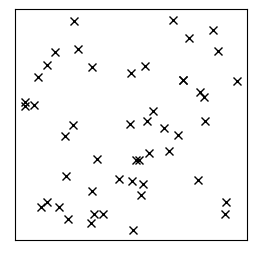

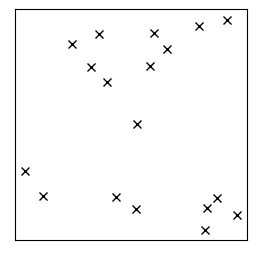

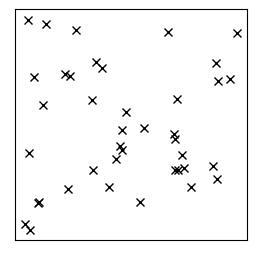

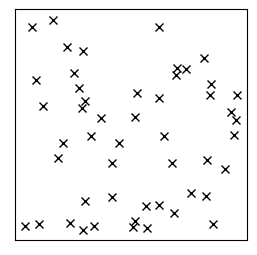

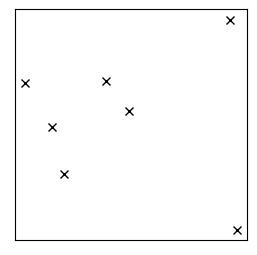

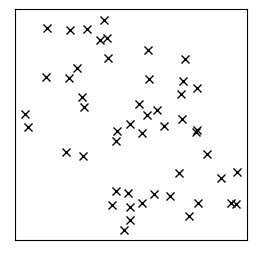

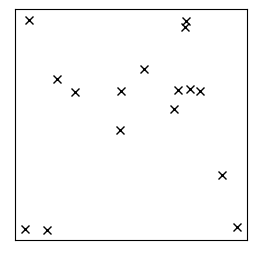

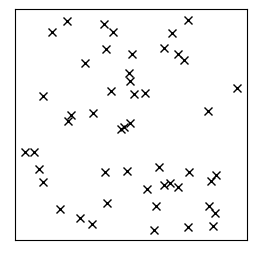

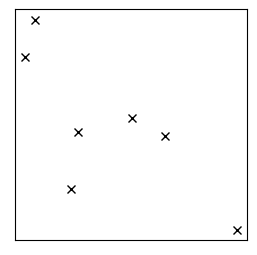

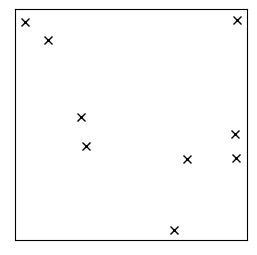

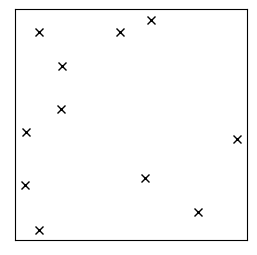

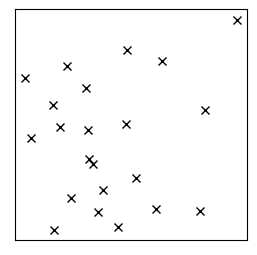

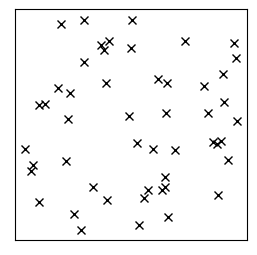

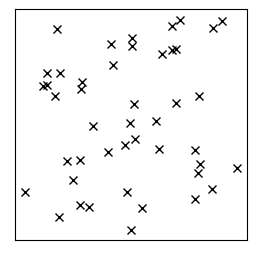

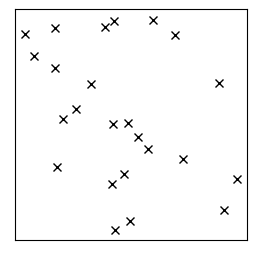

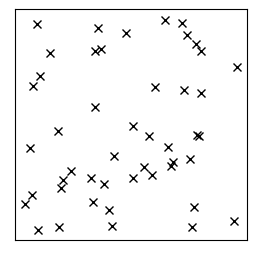

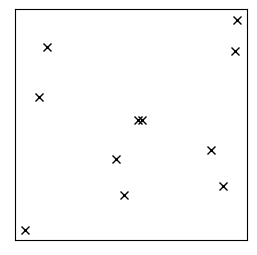

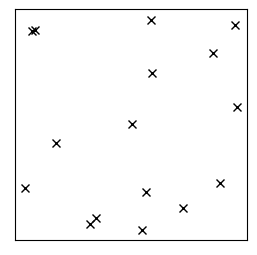

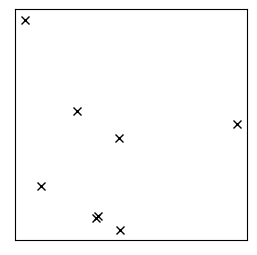

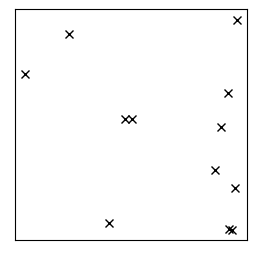

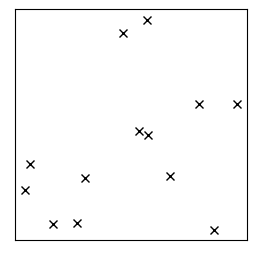

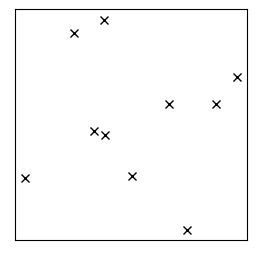

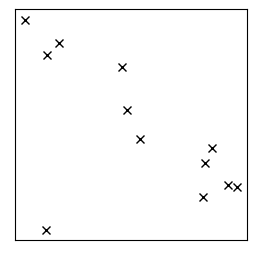

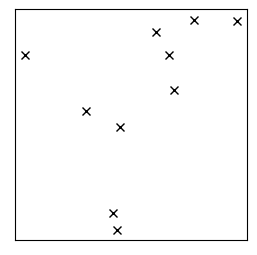

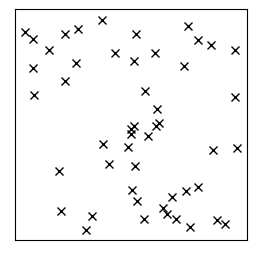

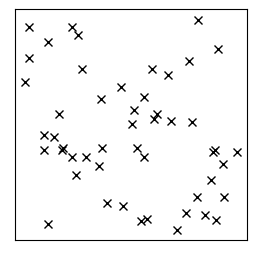

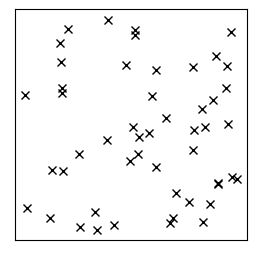

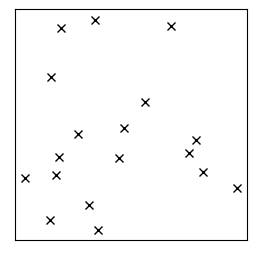

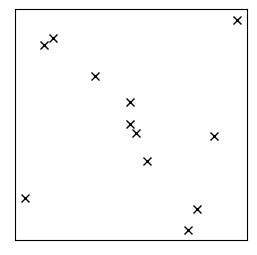

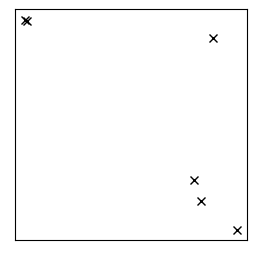

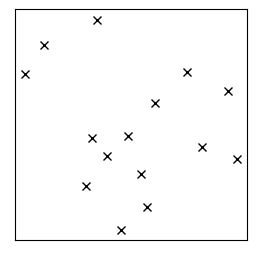

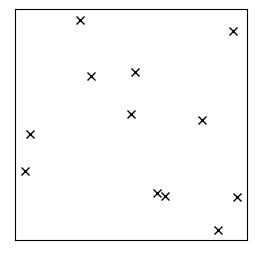

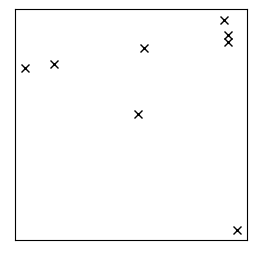

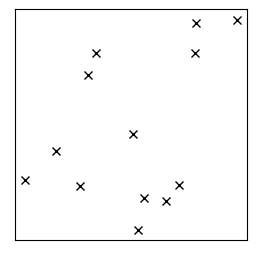

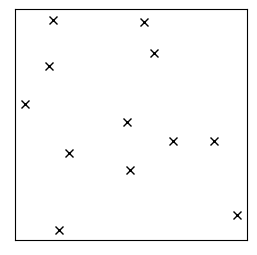

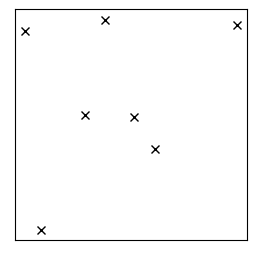

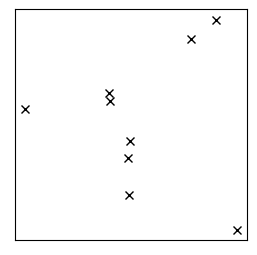

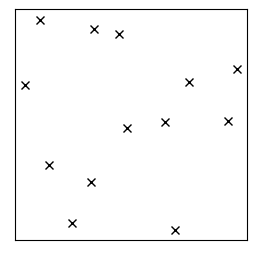

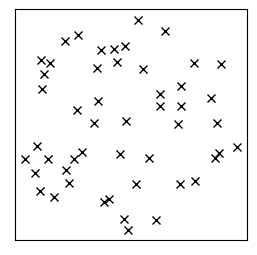

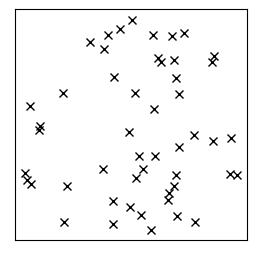

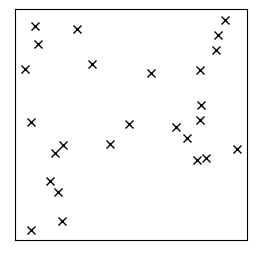

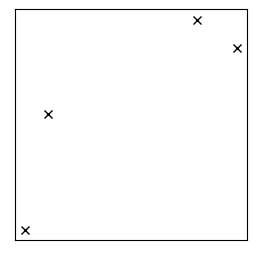

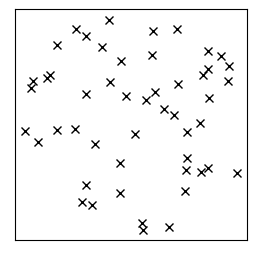

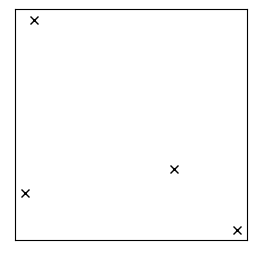

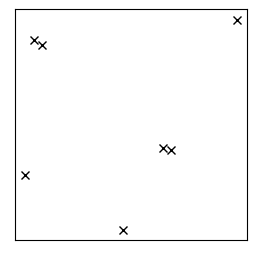

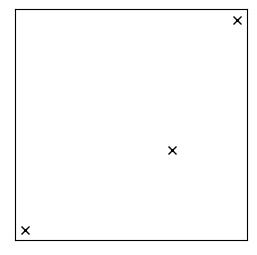

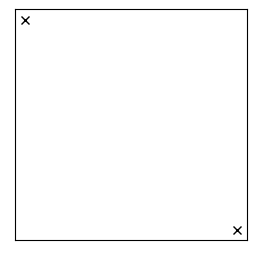

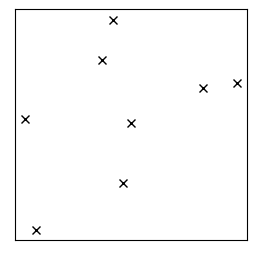

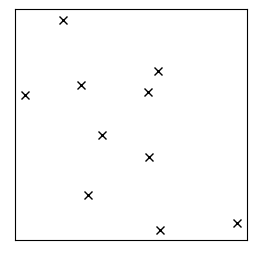

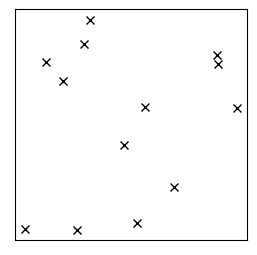

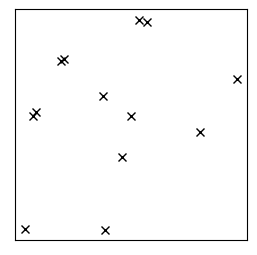

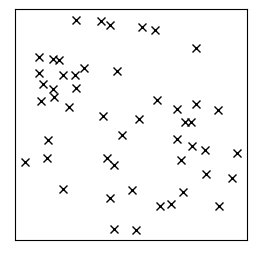

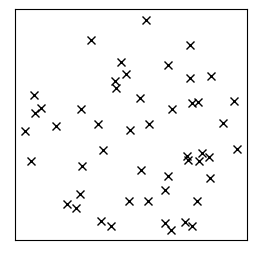

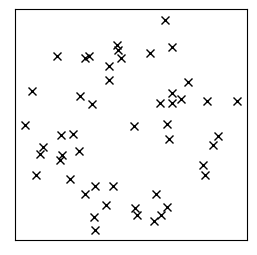

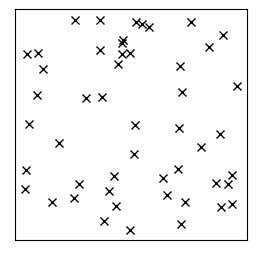

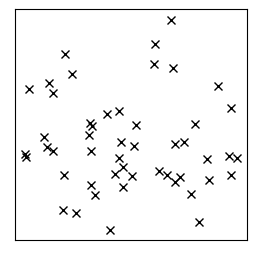

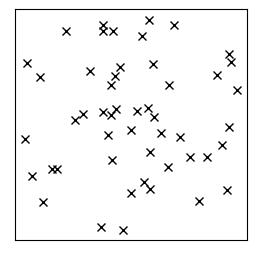

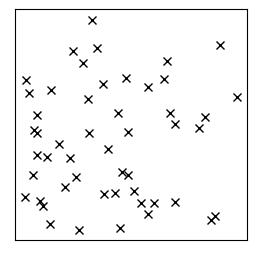

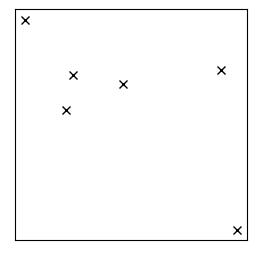

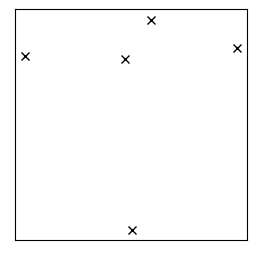

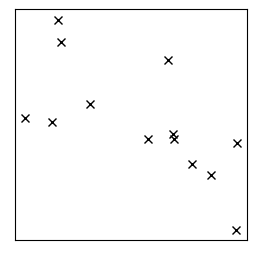

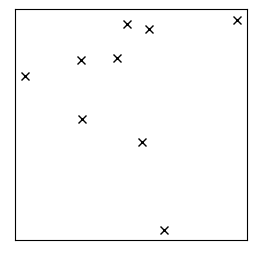

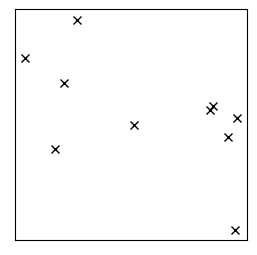

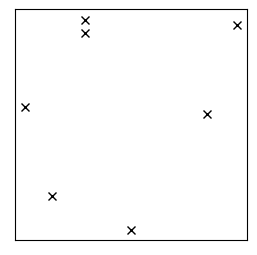

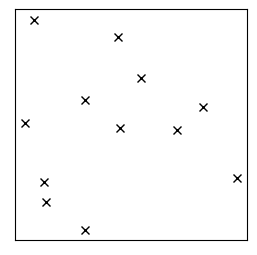

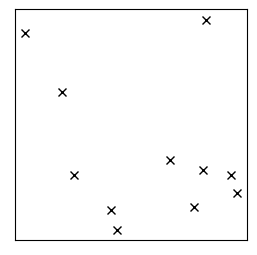

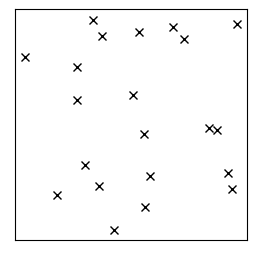

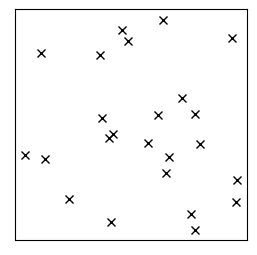

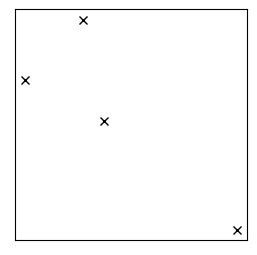

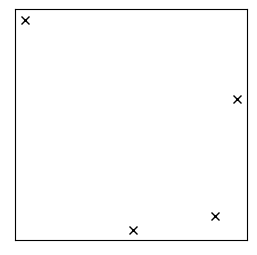

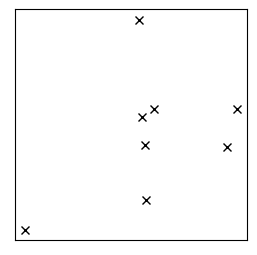

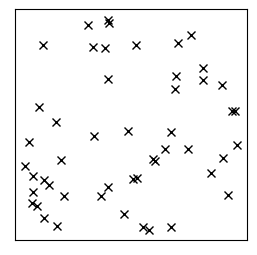

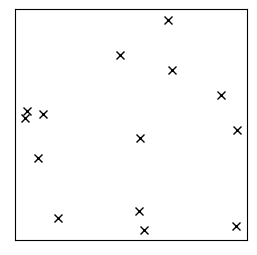

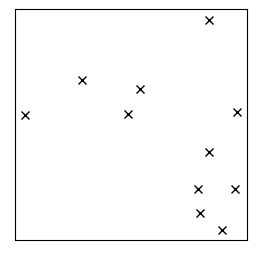

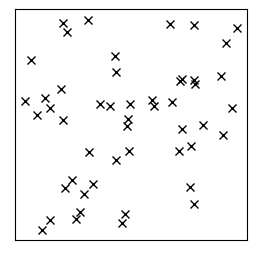

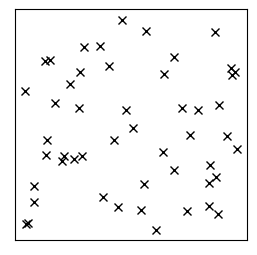

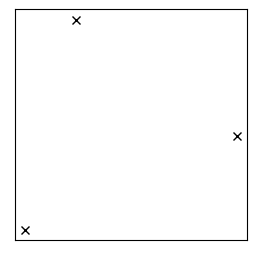

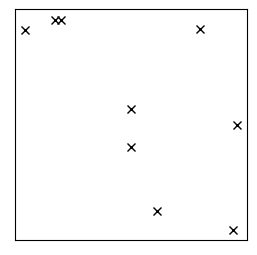

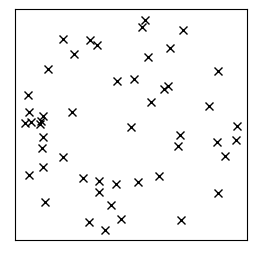

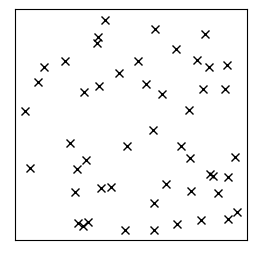

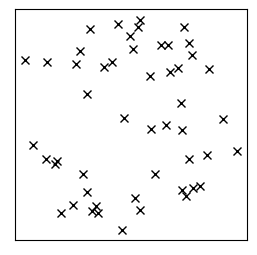

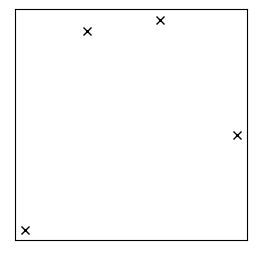

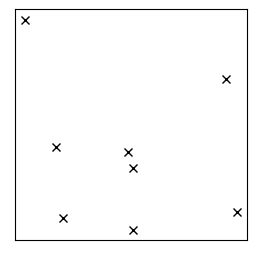

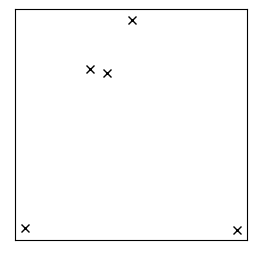

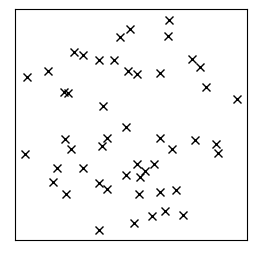

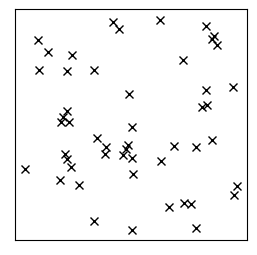

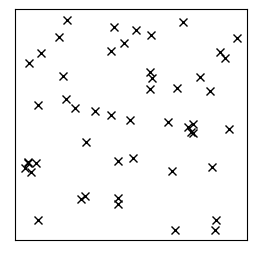

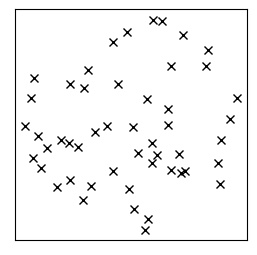

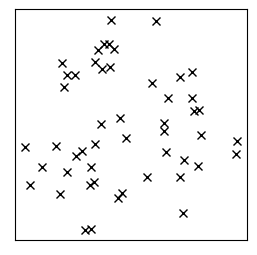

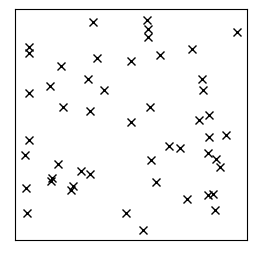

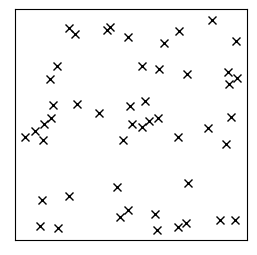

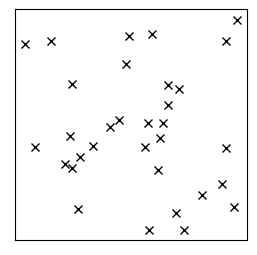

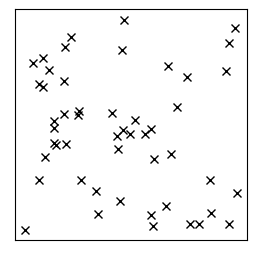

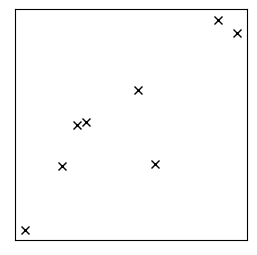

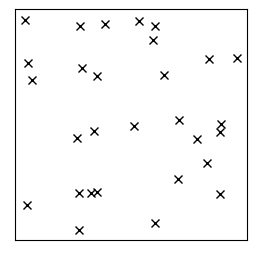

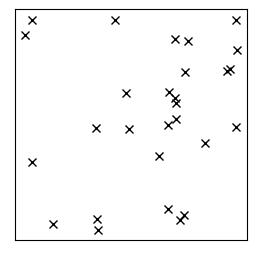

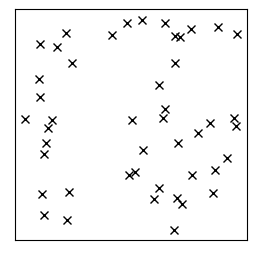

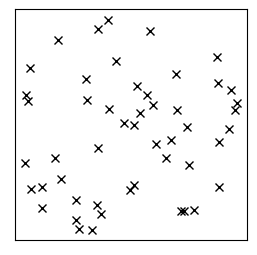

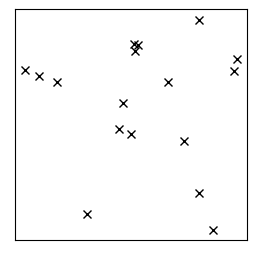

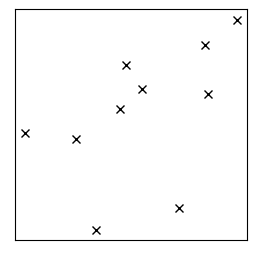

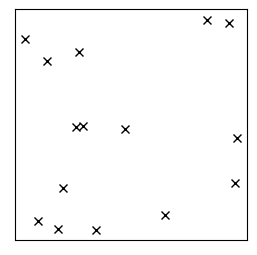

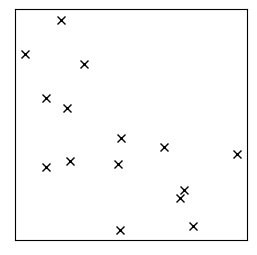

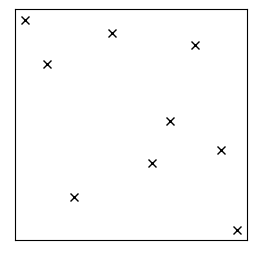

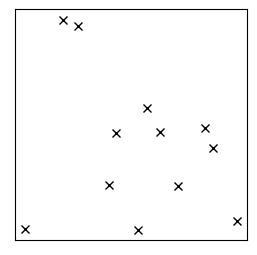

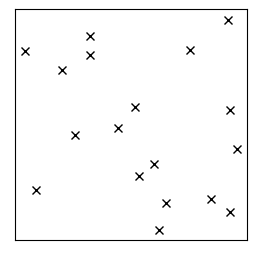

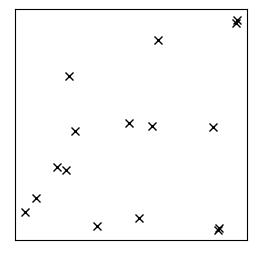

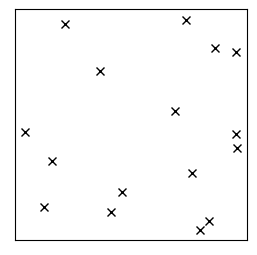

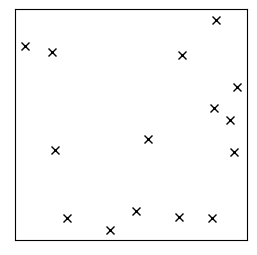

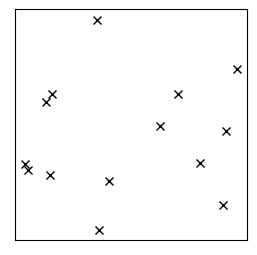

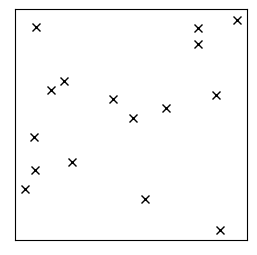

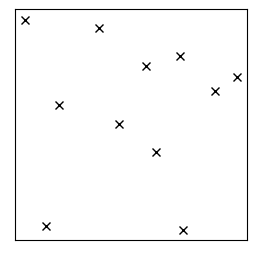

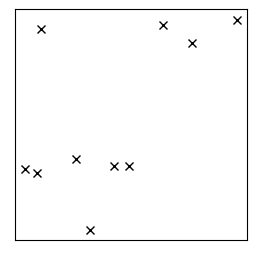

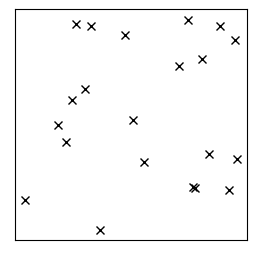

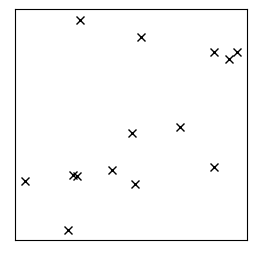

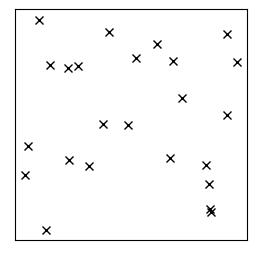

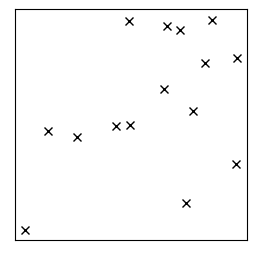

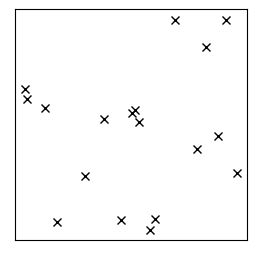

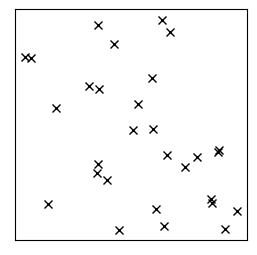

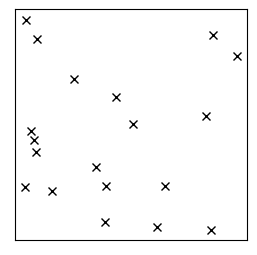

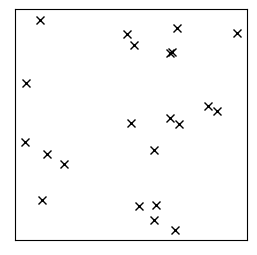

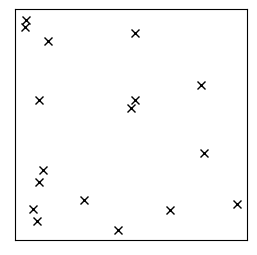

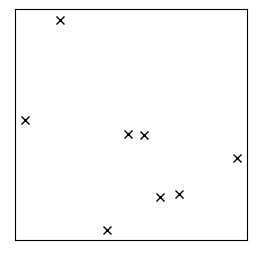

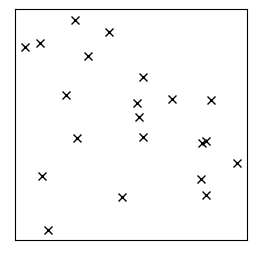

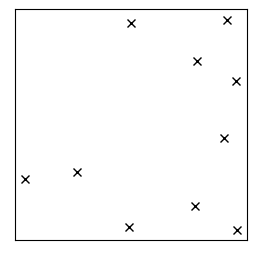

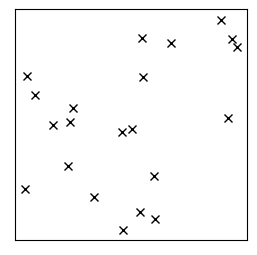

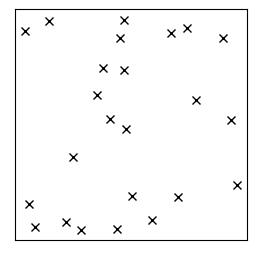

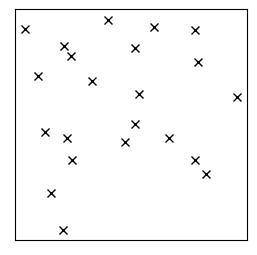

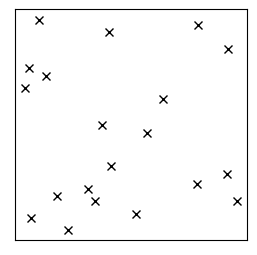

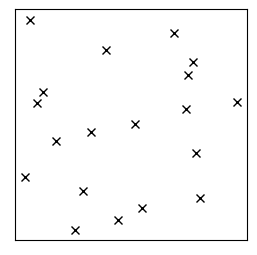

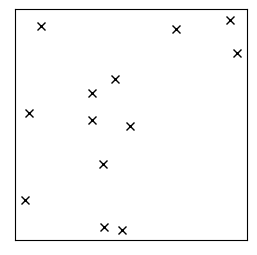

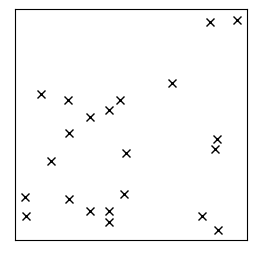

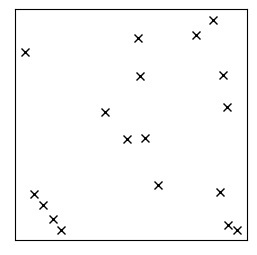

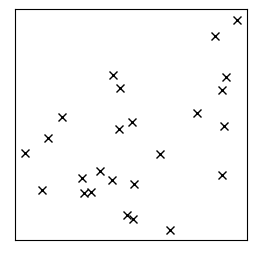

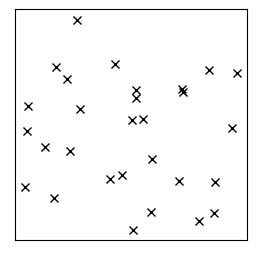

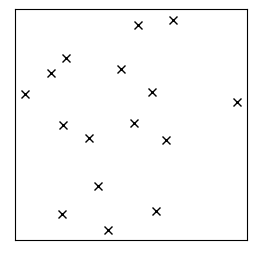

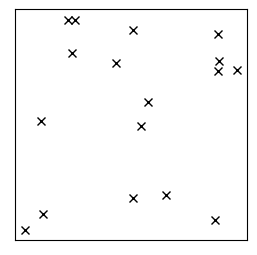

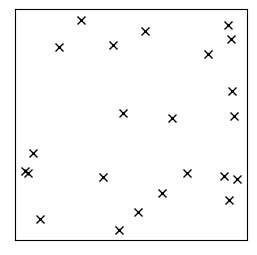

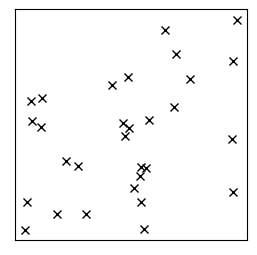

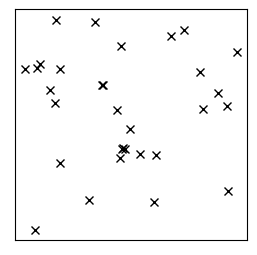

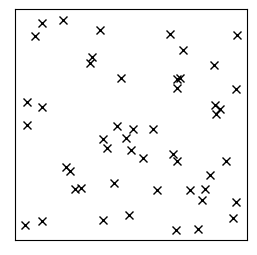

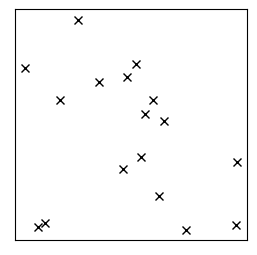

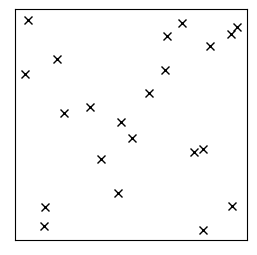

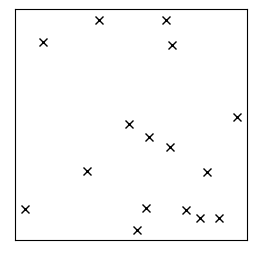

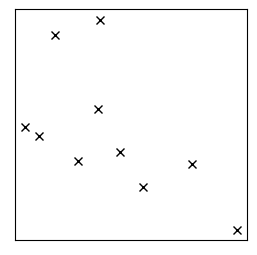

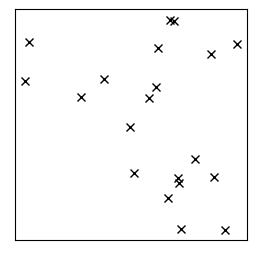

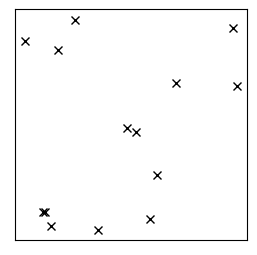

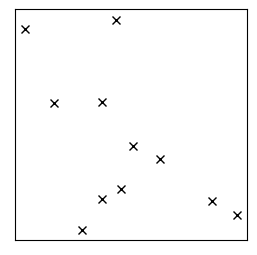

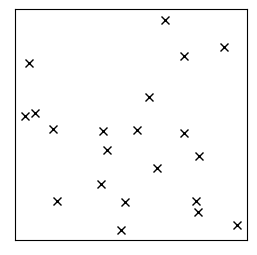

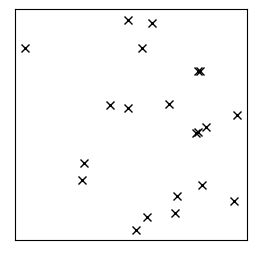

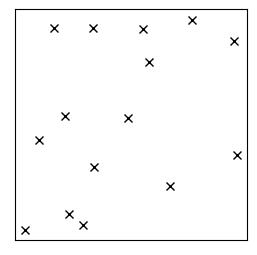

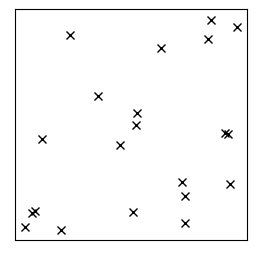

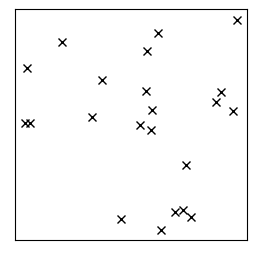

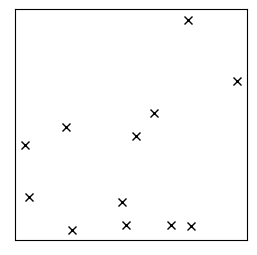

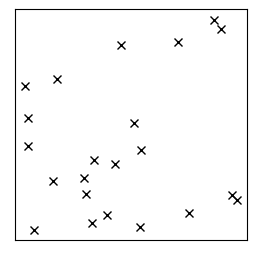

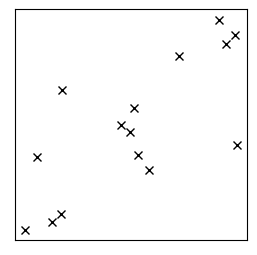

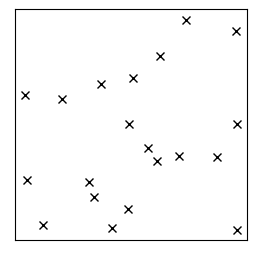

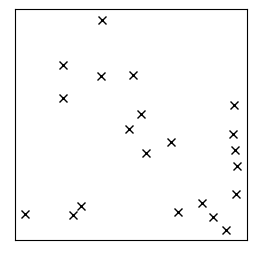

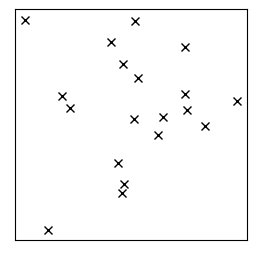

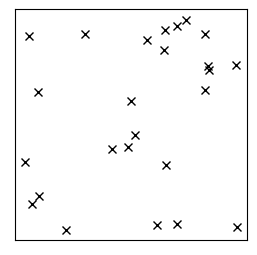

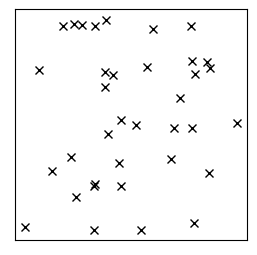

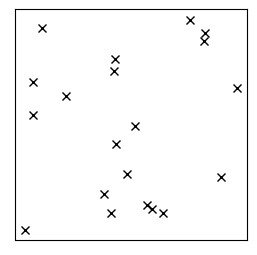

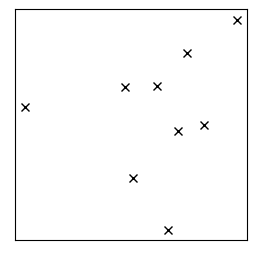

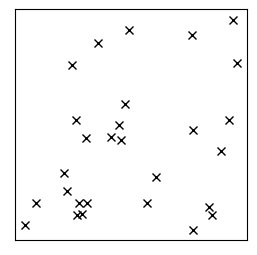

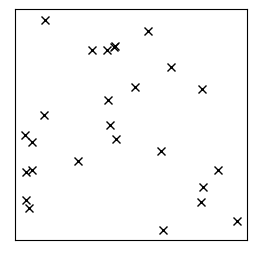

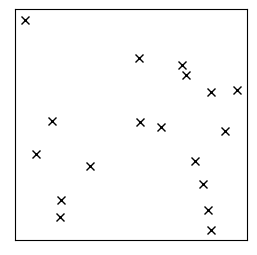

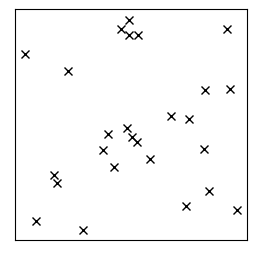

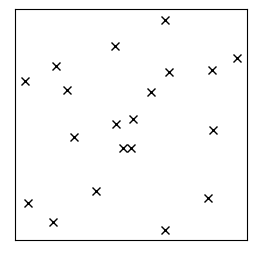

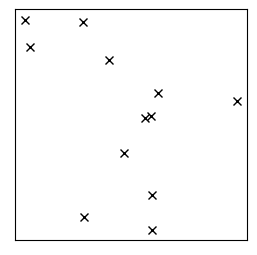

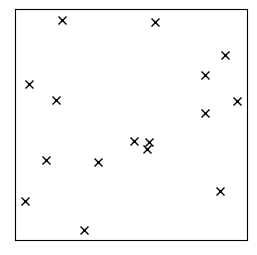

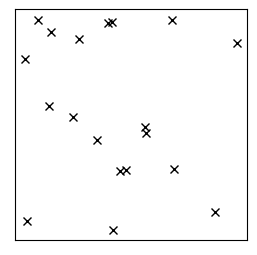

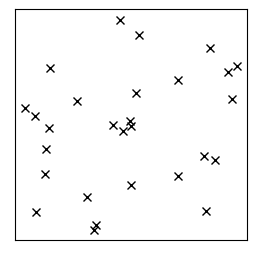

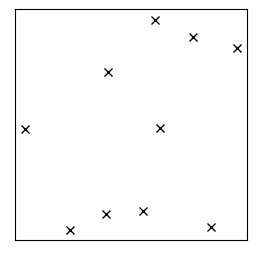

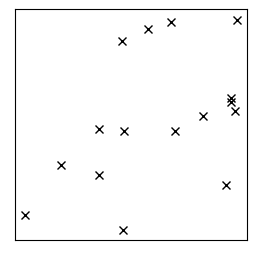

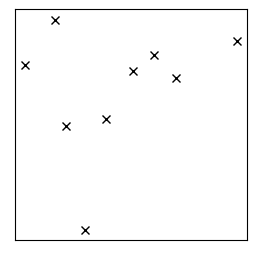

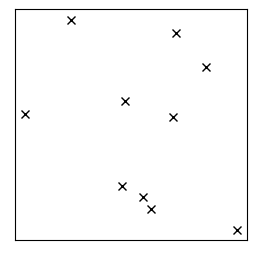

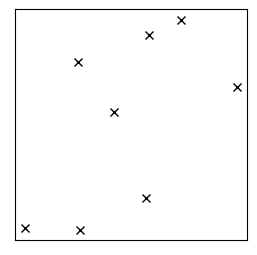

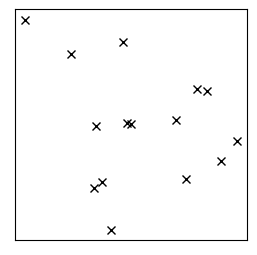

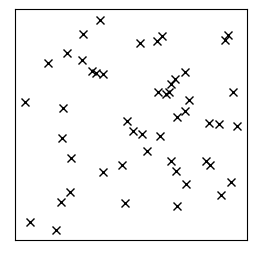

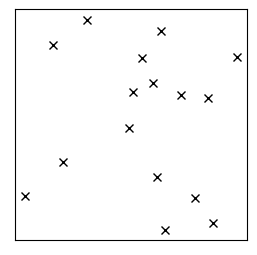

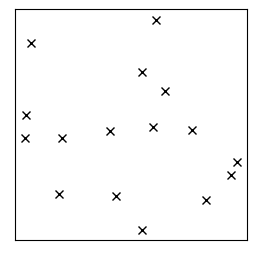

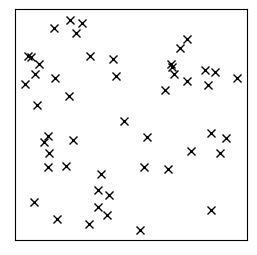

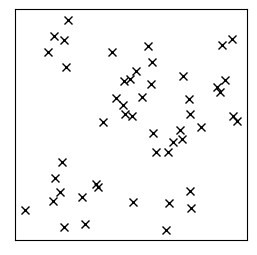

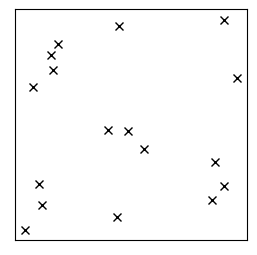

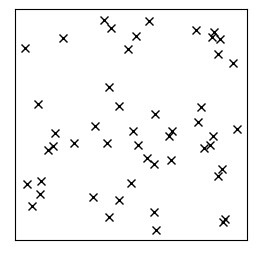

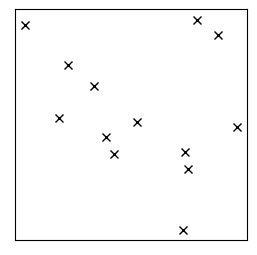

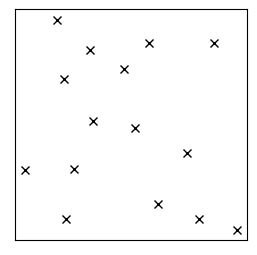

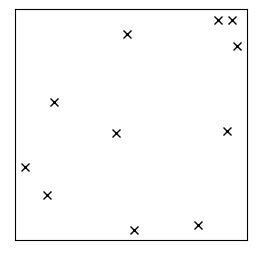

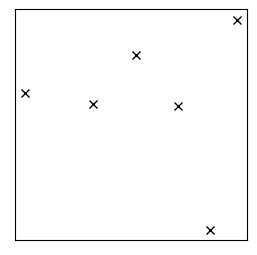

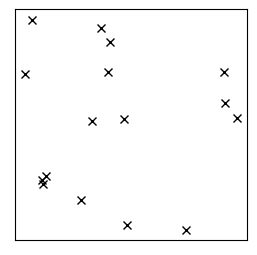

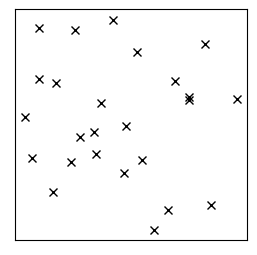

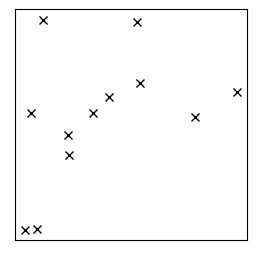

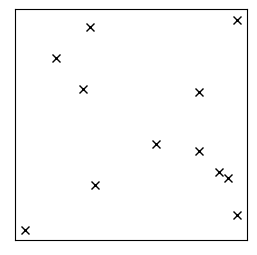

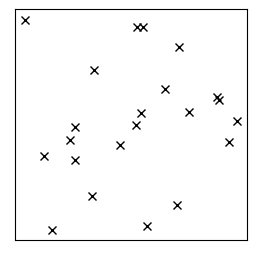

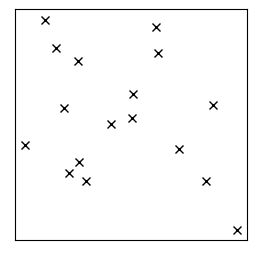

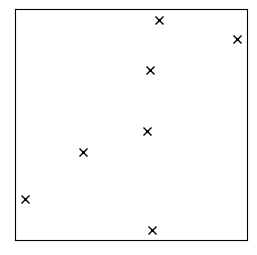

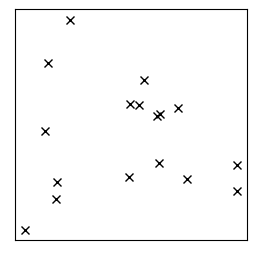

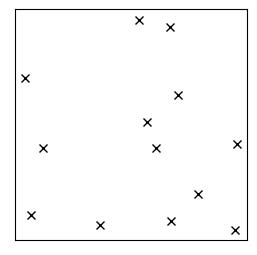

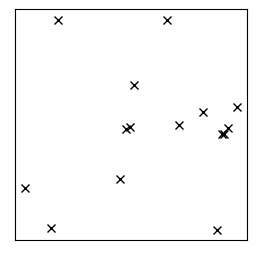

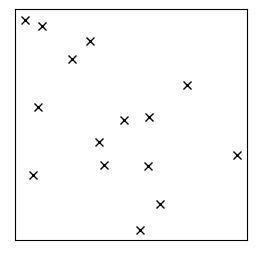

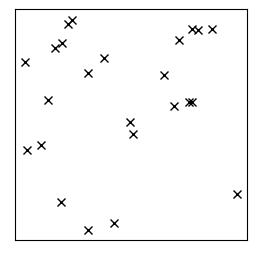

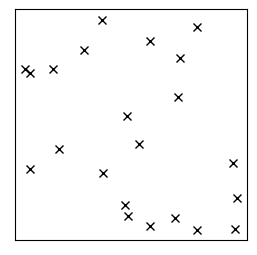

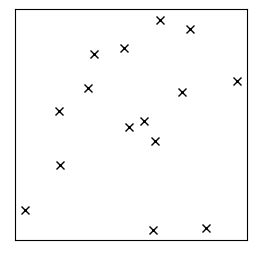

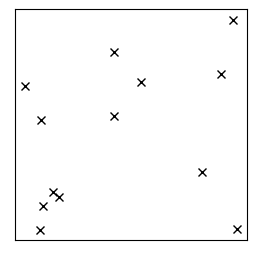

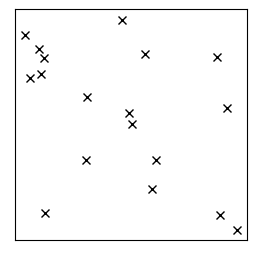

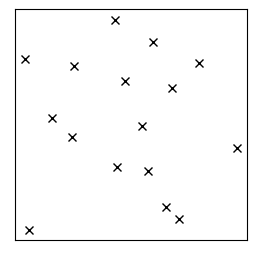

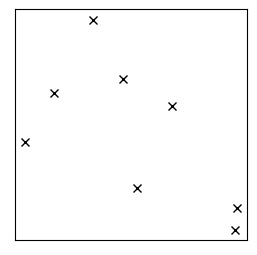

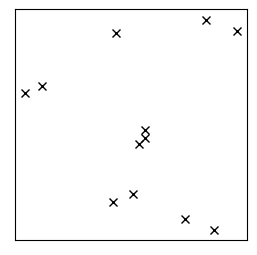

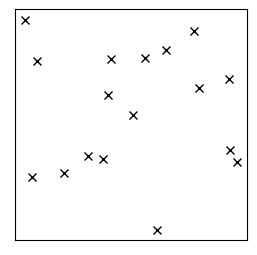

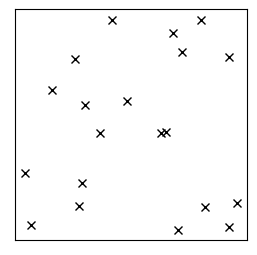

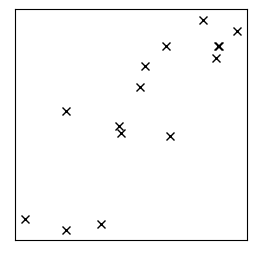

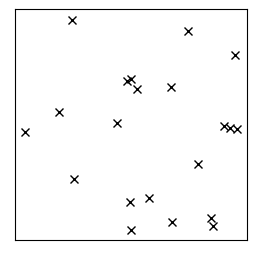

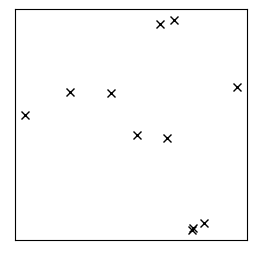

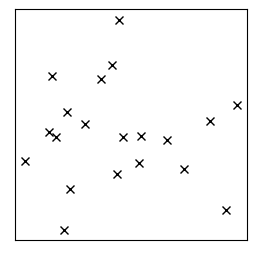

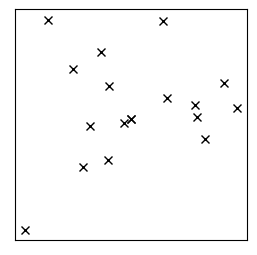

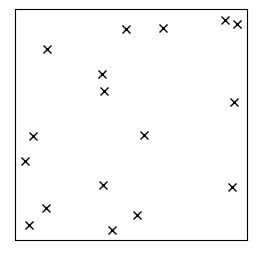

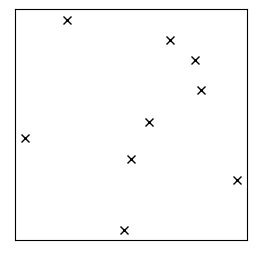

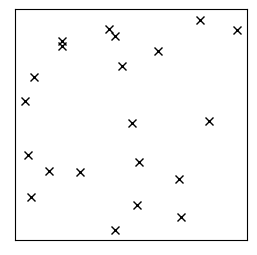

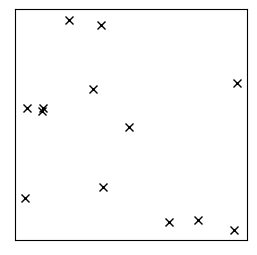

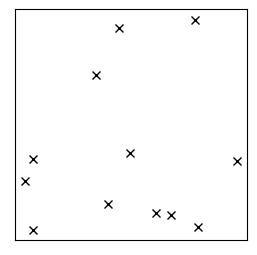

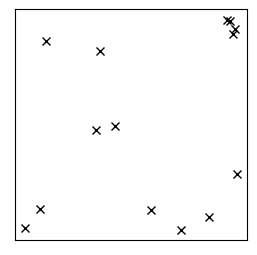

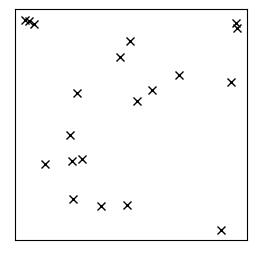

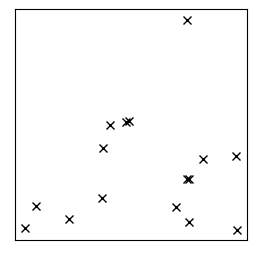

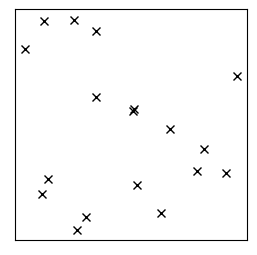

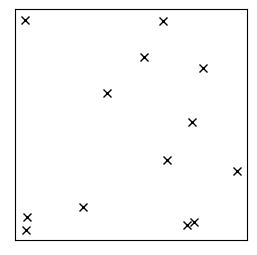

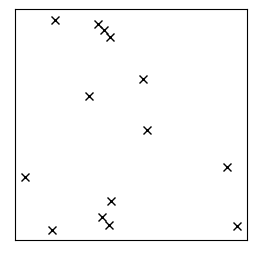

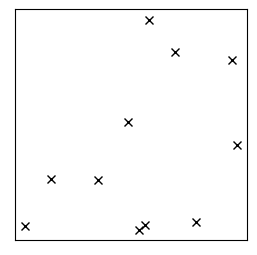

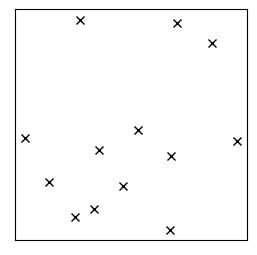

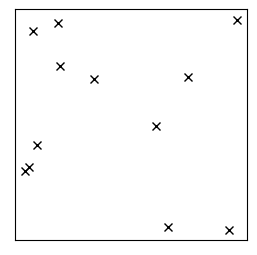

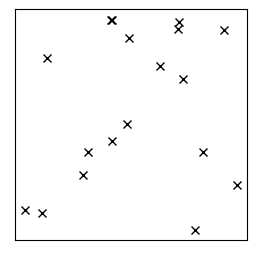

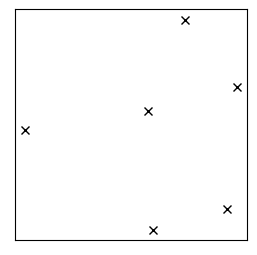

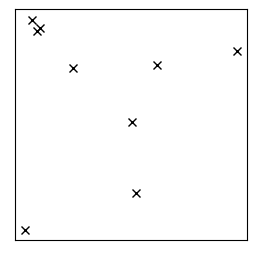

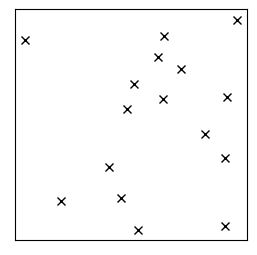

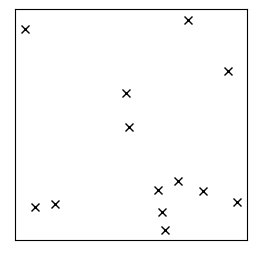

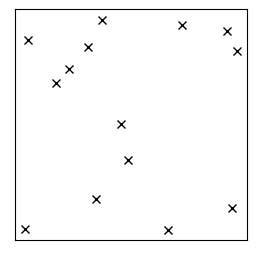

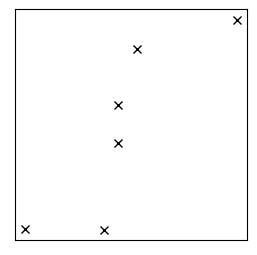

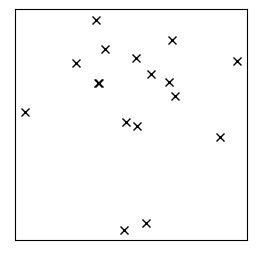

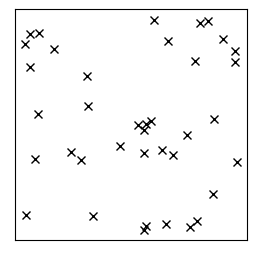

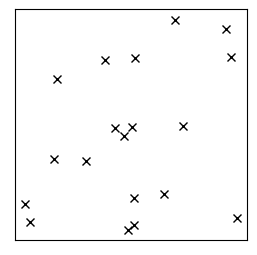

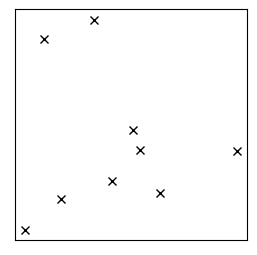

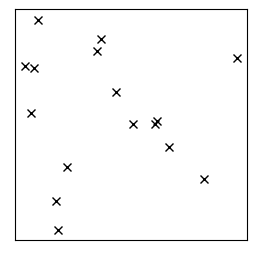

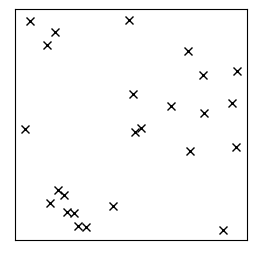

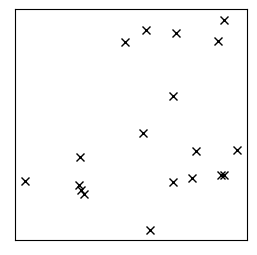

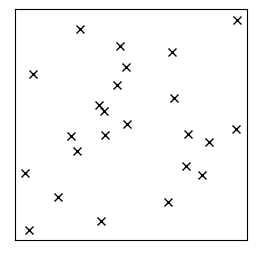

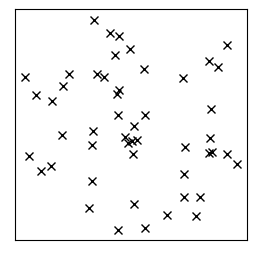

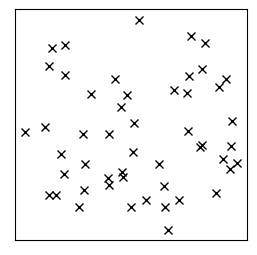

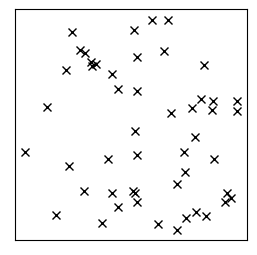

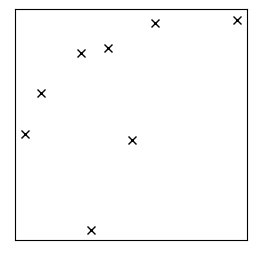

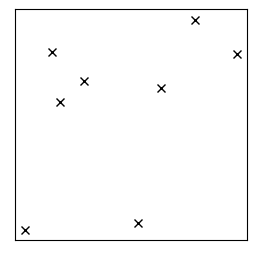

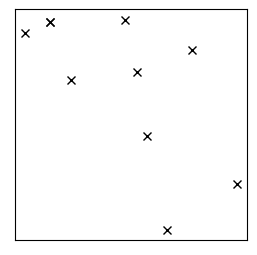

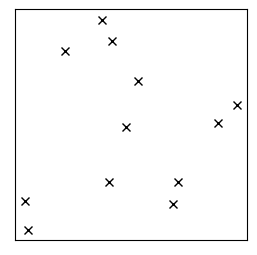

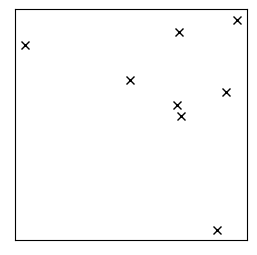

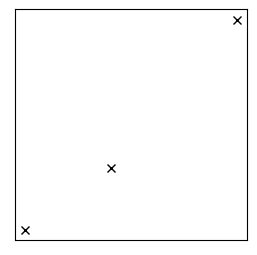

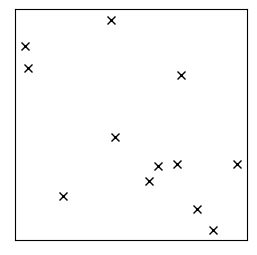

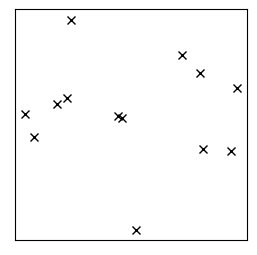

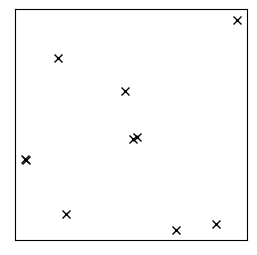

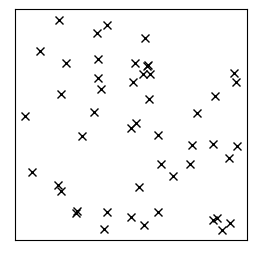

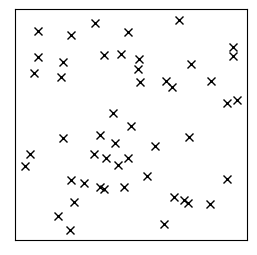

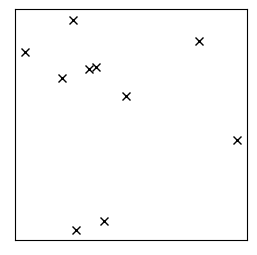

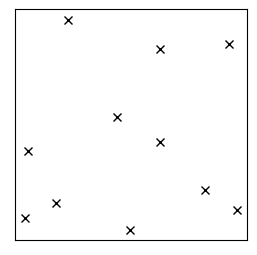

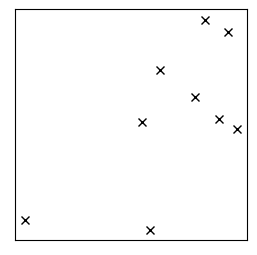

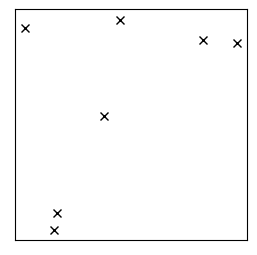

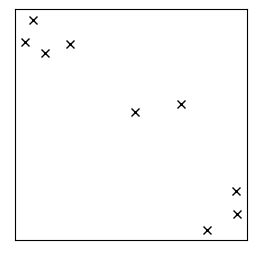

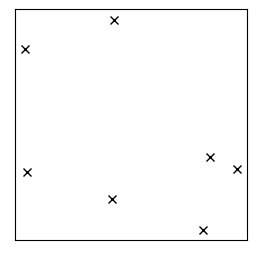

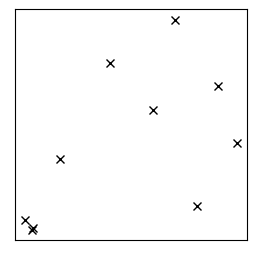

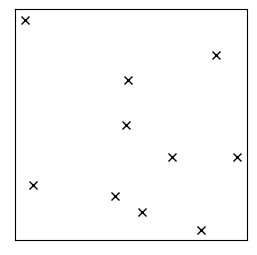

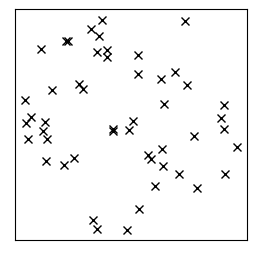

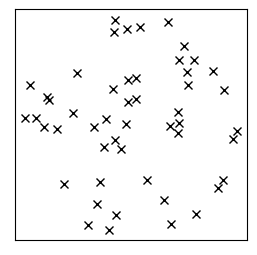

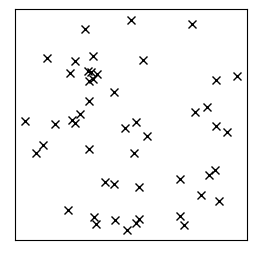

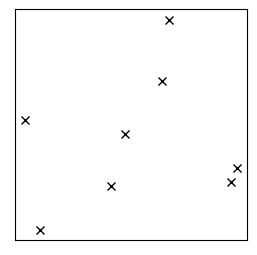

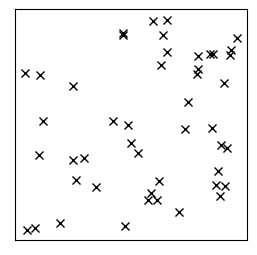

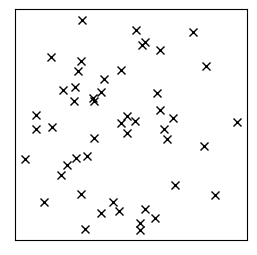

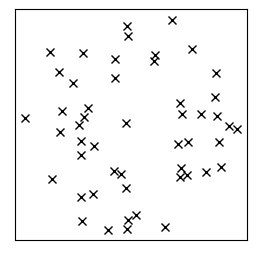

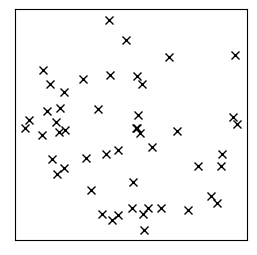

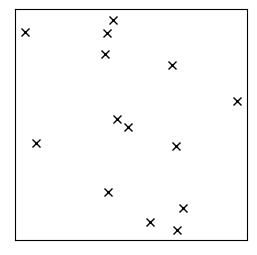

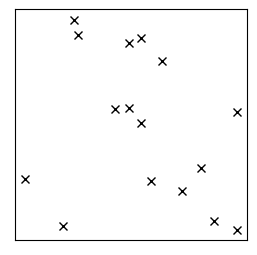

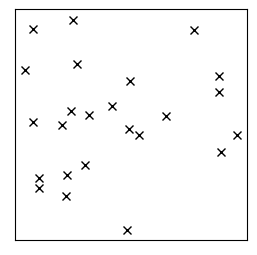

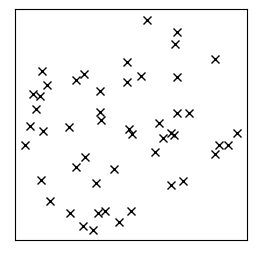

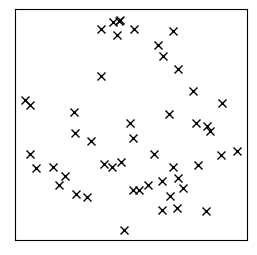

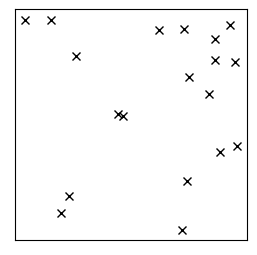

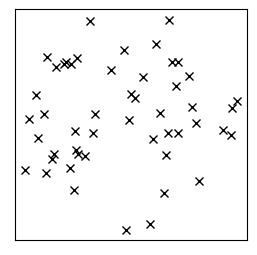

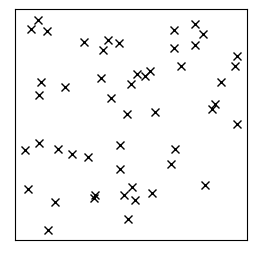

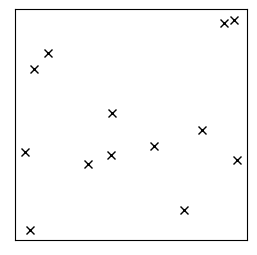

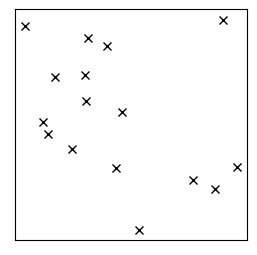

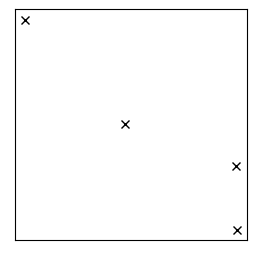

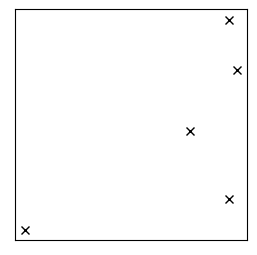

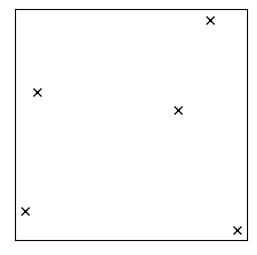

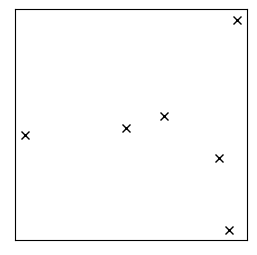

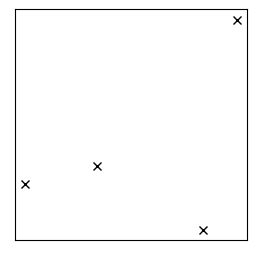

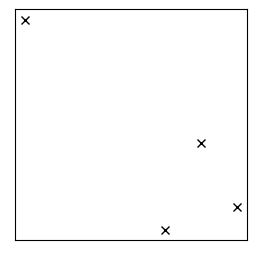

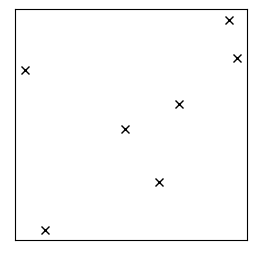

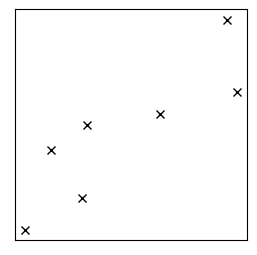

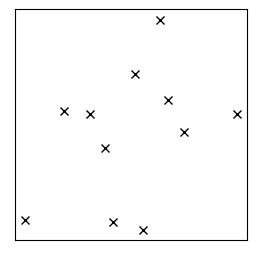

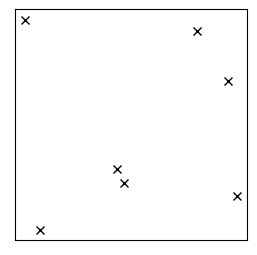

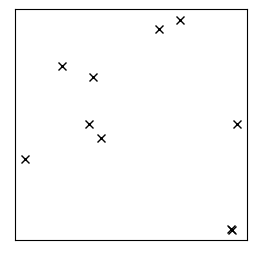

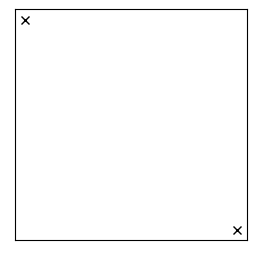

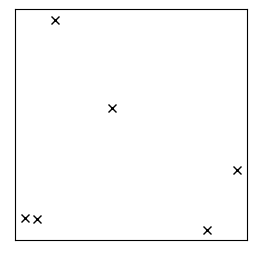

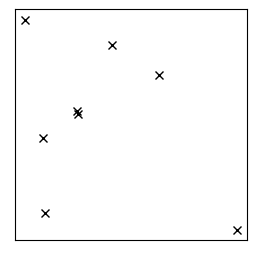

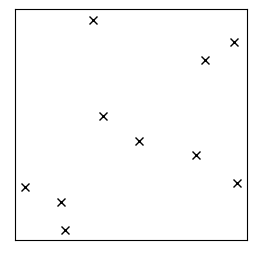

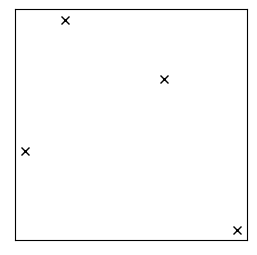

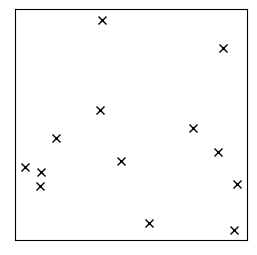

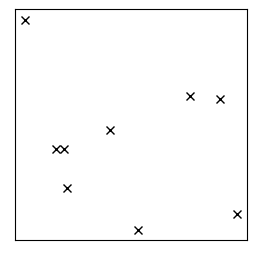

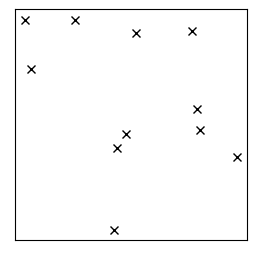

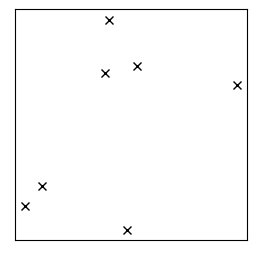

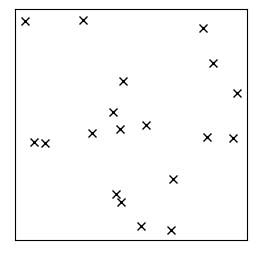

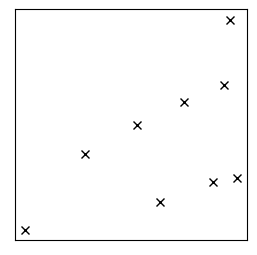

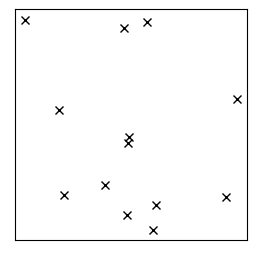

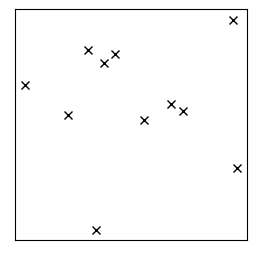

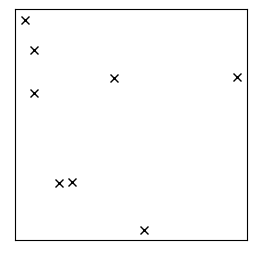

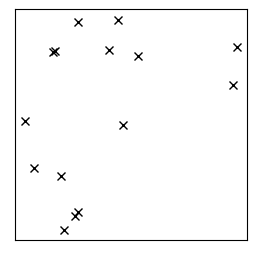

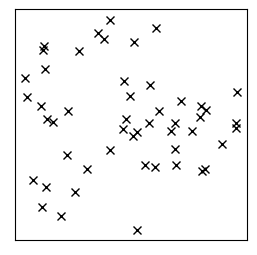

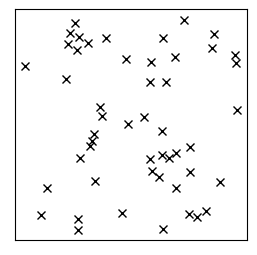

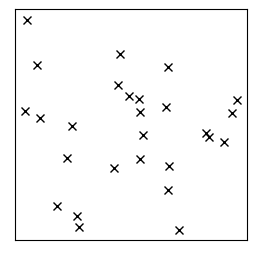

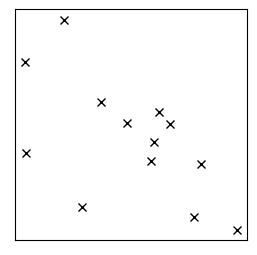

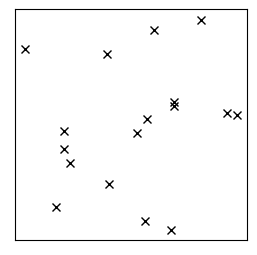

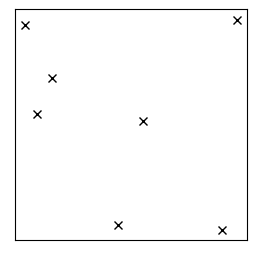

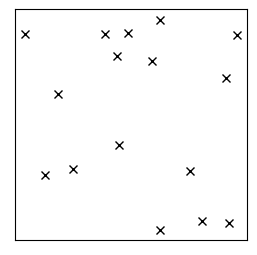

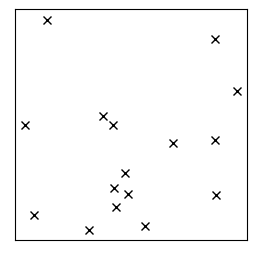

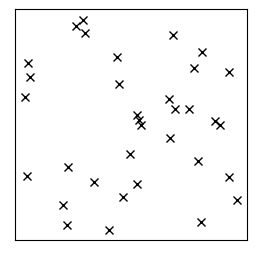

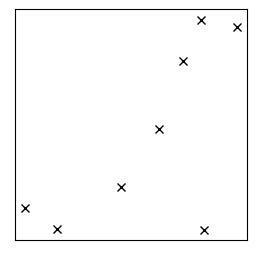

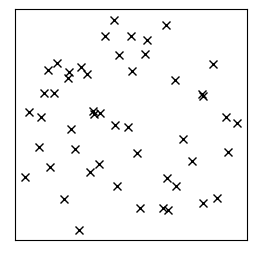

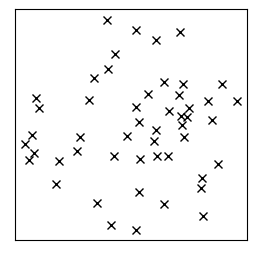

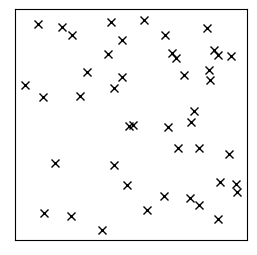

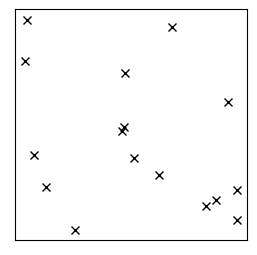

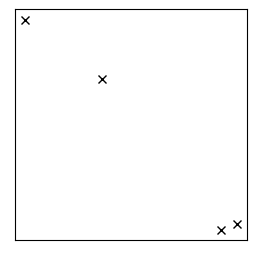

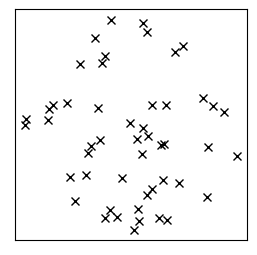

In [34]:
for i in range(len(rs)):
    plt.figure(figsize=(3,3))
    plt.xticks([]);plt.yticks([]);
    
    ra_gaia,dec_gaia = np.array(rs[i]['ra']),np.array(rs[i]['dec'])
    plt.plot(ra_gaia,dec_gaia,'kx')
    
    ix_finite = np.where(np.isfinite(ra_gaia) & np.isfinite(dec_gaia))
    d = angularSeparation(skypos[i][0],skypos[i][1],ra_gaia[ix_finite],dec_gaia[ix_finite])    
    try:
        ix_match = np.argmin(d)
    except ValueError:
        print(f"No matching Gaia source for {i}")
        raise


In [35]:
print('GAIA MATCH OFFSET')
for i in range(len(skypos)): 
    ix_match = np.argmin(rs[i][np.where(d*60*60 < 3)]['parallax_over_error'])
    ix = ix_finite[0][ix_match]
    gaia_match_offset=angularSeparation(skypos[i][0],skypos[i][1],rs[i][ix]['ra'],rs[i][ix]['dec'])*60*60
    print(f"{gaia_match_offset[0]} as")  

GAIA MATCH OFFSET
0.022703755069437146 as
0.2517944888712206 as
0.11648181634389768 as
0.28746796768943556 as
0.2659882540788745 as
0.018828108590350508 as
3.744039405835097 as
2.5478766768451186 as
0.09013191010299042 as
0.0904175966144253 as
4.390271027063702 as
0.18307262336512353 as
2.14824573657819 as
2.6322728763865064 as
0.3020450536166867 as
2.089928533565006 as
0.1828473570442654 as
0.5435085844962362 as
0.08358310404159645 as
0.22279731314589477 as
8.830667388422931 as
0.063250441935219 as
0.3029255870653626 as
0.4632647529238382 as
0.2551496995813908 as
0.11478161588409358 as
0.3956578021126795 as
0.25836526645610375 as
0.17742329319239683 as
0.7690650460089303 as
0.06347078704184565 as
1.7224114726789996 as
0.5885836587874487 as
0.1604039380311233 as
0.13811826624861018 as
1.3523767346917777 as
0.44305915177963406 as
0.1474730542495622 as
0.10635345169261223 as
0.21705127833308702 as
0.3162861175677322 as
0.17689494798482427 as
0.5093144786341941 as
0.24217153010655756 as
5

0.7083313462884457 as
0.2940052146805625 as
0.23673993299700374 as
0.16542936969292216 as
0.3841766684162167 as
0.27129247096249576 as
1.6603517560333507 as
0.034781374618757174 as
4.405916752026578 as
1.061227883247103 as
0.2032828563582668 as
0.764455375312245 as
0.6502151510697094 as
0.10532117034319277 as
0.11447699203634404 as
0.014388152984129045 as
0.100345157159879 as
0.3394029509399809 as
0.4138982166063267 as
2.565680324042275 as
0.05344222823966864 as
0.2122798223142744 as
0.5527959365753699 as
0.12895811802494844 as
0.04397878474516497 as
0.0470822040437606 as
2.3202171407570367 as
0.09677681575438526 as
0.11611406529802708 as
0.23249592246269568 as
0.8769727402031338 as
0.20450999573419942 as
0.20146640739416538 as
0.17669828339998261 as
11.264268000687887 as
0.5355877807045014 as
0.38390699539147377 as
0.4830429030073747 as
2.4565067718770837 as
1.1388756382352994 as
1.8337522446591514 as
0.24109344920278125 as
0.6709261652238903 as
0.0386406412514029 as
0.262324146318851

In [36]:
d_pc = []
print('GAIA ID & DISTANCES')
for i in range(len(rs)):
    gaia_dr3_source_id=rs[i][ix]['source_id']
    par,par_err = rs[i][ix]['parallax'],rs[i][ix]['parallax_error']
    gaia_distance=1000/par
    d_pc.append(gaia_distance)
    print(gaia_dr3_source_id,'@',f'{gaia_distance} parsecs')
    

GAIA ID & DISTANCES
6119573002250228096 @ 318.1903270160917 parsecs
6121149186525695488 @ 248.06634818971241 parsecs
6119528334597735296 @ 19.32792542890933 parsecs
6103240203697723392 @ 137.16893923472531 parsecs
6099012478412247296 @ 123.5726138143696 parsecs
6112184627714286848 @ 663.427584240853 parsecs
6114232429458639360 @ 669.4979227554321 parsecs
6114478964882542848 @ 103.78365776937258 parsecs
6111249046398224640 @ 435.8335667565865 parsecs
6120558199028073856 @ 965.7905625719771 parsecs
6109949904687424640 @ 9.113087182469068 parsecs
6116222927763847296 @ 580.5933624889537 parsecs
6116110468338455680 @ 15.029353902664667 parsecs
6109610086872510592 @ 9.940109628042029 parsecs
6097027546386964352 @ 161.51375406669314 parsecs
6096529059601571200 @ 15.38402607369578 parsecs
6096705840454620800 @ 5066.554549713511 parsecs
6096618257480937344 @ 59.878604552212714 parsecs
6093354151058689664 @ 513.5108051787222 parsecs
5999414042261259264 @ 179.67166673645212 parsecs
59027502369960

In [37]:
gpoe=[]
for i in range(len(rs)):
    gaia_parallax_over_err = rs[i][ix]['parallax_over_error']
    gpoe.append(gaia_parallax_over_err)

In [38]:
skypos

[(214.255, -35.9581),
 (213.2423, -35.7818),
 (216.0779, -35.2428),
 (217.0805, -42.3263),
 (217.6092, -46.1596),
 (206.9106, -41.6917),
 (209.5359, -39.6373),
 (210.2554, -38.0514),
 (210.9181, -40.0504),
 (211.4009, -37.458),
 (212.9939, -41.5402),
 (213.2045, -40.3602),
 (214.3548, -40.3042),
 (210.9617, -42.6998),
 (212.3994, -44.3672),
 (214.1947, -44.8886),
 (214.3773, -44.0493),
 (214.8433, -44.6792),
 (215.6425, -45.4868),
 (232.8602, -45.7855),
 (230.4361, -48.3193),
 (229.5317, -44.5094),
 (229.2468, -38.4477),
 (231.1873, -39.7106),
 (231.5284, -39.8891),
 (232.4555, -41.0721),
 (231.9099, -45.0357),
 (232.5774, -42.98),
 (223.6587, -38.7445),
 (223.7273, -41.3653),
 (223.8183, -39.7204),
 (235.296, -44.6628),
 (237.4074, -39.9158),
 (224.1986, -41.9984),
 (224.3724, -46.2419),
 (224.936, -43.8121),
 (225.3195, -43.6585),
 (225.8877, -45.256),
 (228.185, -47.9639),
 (235.1832, -32.0668),
 (232.6542, -35.9182),
 (231.8896, -29.5293),
 (229.9801, -25.0067),
 (230.4614, -25.236

In [39]:
 
### LEGAL VOTable fields defined in:
### https://github.com/astropy/astroquery/blob/main/astroquery/simbad/data/votable_fields_dict.json
import time
r2s=[]
for i in range(len(rs)):
    time.sleep(1)
    Simbad.add_votable_fields("otype","parallax","sp")
    time.sleep(1)
    r2 = Simbad.query_region(coord.SkyCoord(skypos[i][0],skypos[i][1],
                            unit=(u.deg, u.deg)),#, frame='icrs'),
                            radius=35/60/60*u.deg)
    time.sleep(1)
    print(skypos[i])
    r2s.append(r2)

(214.255, -35.9581)
(213.2423, -35.7818)
(216.0779, -35.2428)
(217.0805, -42.3263)
(217.6092, -46.1596)
(206.9106, -41.6917)
(209.5359, -39.6373)
(210.2554, -38.0514)
(210.9181, -40.0504)
(211.4009, -37.458)
(212.9939, -41.5402)
(213.2045, -40.3602)
(214.3548, -40.3042)
(210.9617, -42.6998)
(212.3994, -44.3672)
(214.1947, -44.8886)
(214.3773, -44.0493)
(214.8433, -44.6792)
(215.6425, -45.4868)
(232.8602, -45.7855)
(230.4361, -48.3193)
(229.5317, -44.5094)
(229.2468, -38.4477)
(231.1873, -39.7106)
(231.5284, -39.8891)
(232.4555, -41.0721)
(231.9099, -45.0357)
(232.5774, -42.98)
(223.6587, -38.7445)
(223.7273, -41.3653)
(223.8183, -39.7204)
(235.296, -44.6628)
(237.4074, -39.9158)
(224.1986, -41.9984)
(224.3724, -46.2419)
(224.936, -43.8121)
(225.3195, -43.6585)
(225.8877, -45.256)
(228.185, -47.9639)
(235.1832, -32.0668)
(232.6542, -35.9182)
(231.8896, -29.5293)
(229.9801, -25.0067)
(230.4614, -25.2369)
(230.5573, -27.8245)
(236.3421, -27.6689)
(238.1879, -26.3902)
(238.5049, -29.8275)


(107.8419, -70.7742)
(108.7551, -69.772)
(111.6157, -70.8261)
(112.2534, -70.239)
(112.9157, -68.1332)
(115.165, -69.1416)
(116.7665, -66.2345)
(116.5623, -66.9862)
(116.6859, -67.75)
(117.1243, -67.7569)
(118.307, -67.8009)
(119.3873, -71.2482)
(120.9705, -69.881)
(121.5091, -71.043)
(121.7289, -66.3064)
(121.9488, -70.2274)
(124.5333, -68.315)
(121.2259, -63.7714)
(121.1684, -64.4977)
(124.2694, -63.2134)
(106.0602, -62.9025)
(106.7452, -62.3532)
(106.9111, -62.3781)
(107.921, -65.5088)
(108.0195, -61.1639)
(108.316, -64.8734)
(108.8378, -60.378)
(109.2049, -60.3506)
(109.1556, -64.1244)
(109.4547, -65.2141)
(110.2132, -62.1687)
(111.0206, -61.415)
(111.7157, -65.8852)
(112.01, -63.5178)
(113.6764, -61.0827)
(113.7696, -63.0394)
(114.4673, -62.0783)
(115.7396, -63.7019)
(116.5936, -64.0557)
(116.5014, -61.8798)
(100.3749, -65.469)
(100.3168, -64.3598)
(117.2148, -63.7201)
(115.455, -68.0283)
(116.0861, -69.5105)
(114.8857, -66.444)
(105.0705, -65.1461)
(105.2922, -63.2006)
(111.961, 

In [40]:
spectral_type=[]
for i in range(len(r2s)):
    try:
        spec_type = r2s[i]['SP_TYPE']
        spectral_type.append(spec_type)
        
    except TypeError:
        spec_type = 0
        spectral_type.append(spec_type)
len(spectral_type)

604

### TARGET TABLE

In [41]:
ID=[]
position = []
distance=[]
for i in range(len(rs)):
    
    name = rs[i][ix]['source_id']
    ID.append(name)
    ra = rs[i][ix]['ra']
    dec = rs[i][ix]['dec']
    pos = (ra,dec)
    position.append(pos)
    dist = d_pc[i]
    distance.append(dist)

target_table = pd.DataFrame({
                    'ID': ID,
                    'Position': position,
                    'Distance (pc)': distance,
                    'Spectral Type': spectral_type})
#target_table.to_csv('target_table_v1.csv')

In [42]:
target_table

,ID,Position,Distance (pc),Spectral Type
0,6119573002250228096,"(214.25500631728866, -35.95809630876423)",318.190327,[]
1,6121149186525695488,"(213.24226241844866, -35.78173705167853)",248.066348,[]
2,6119528334597735296,"(216.07789507666112, -35.242767894759034)",19.327925,[M6.5]
3,6103240203697723392,"(217.08056406163018, -42.32623571004951)",137.168939,[G8IV(e)]
4,6099012478412247296,"(217.60920221164744, -46.15952613025638)",123.572614,"[, , ]"
...,...,...,...,...
599,4663673165895470720,"(78.70799371942981, -65.02086547093589)",711.084451,0
600,4664755291470248064,"(74.7181157919168, -63.85922793545928)",433.979842,[]
601,4675137120775840128,"(64.72651677201816, -64.58996732248187)",193.476931,[]
602,4678025262942781696,"(69.8522520008595, -59.590567969253605)",146.144361,[]


In [43]:
path = '/Users/katborski/Documents/GitHub/QPPs/sector_39/'

In [44]:
# open data & create list of datafiles
event_files = []
for visit in os.listdir(path):
    vis_path = path+visit
    event_files+=[vis_path]

#datafiles = fits.open(event_files)

# create list of distances in parsecs, previously defined as d_pc
distances = d_pc

In [45]:
len(event_files)

1001

In [47]:
ranges=[]
for i in range(len(event_files)-1):
    # 9,19,27 & 31 produce different indexing errors
    # 14,15 & 30 produce empty/corrupt fits file errors
    try:
        flaring_frame = dataClean(event_files[i])
        q_frame = generate_Qcurve(flaring_frame)
        flare_ranges = find_flare_ranges(flaring_frame,q_frame,3,quiescence=None)
        print(i)
        ranges.append(len(flare_ranges[0]))
    except:
        print(event_files[i])
        ### flare_ranges contains 2 elements: 
        ###    [0] = flare_ranges,
        ###    [1] = flare_flux
    #flare_total_energies = energycalculation2(flaring_frame,q_frame,flare_ranges,binsize=20)
    #qpp_data = qpp_find(flaring_frame,flare_ranges[0],flare_ranges[1])
        ### qpp_data contains 5 elements: 
        ###    [0] = large_flare_data,
        ###    [1] = large_flare_time,
        ###    [2] = large_flare_det, 
        ###    [3] = large_flare_params, 
        ###    [4] = large_flare_fits
    #residuals, res_fits = fit_residuals(qpp_data[0],qpp_data[4])
    #flare_table = FlareTable(flaring_frame,flare_ranges,flare_total_energies)
print(len(ranges))

0
1
2
3
4
5
6
7
8
/Users/katborski/Documents/GitHub/QPPs/sector_39/tess2021146024351-s0039-0000000324849364-0210-a_fast-lc.fits
10
11
12
13
/Users/katborski/Documents/GitHub/QPPs/sector_39/tess2021146024351-s0039-0000000351808240-0210-a_fast-lc.fits
/Users/katborski/Documents/GitHub/QPPs/sector_39/tess2021146024351-s0039-0000000294750180-0210-a_fast-lc.fits
16
17
18
/Users/katborski/Documents/GitHub/QPPs/sector_39/tess2021146024351-s0039-0000000218450024-0210-a_fast-lc.fits
20
21
22
23
24
25
26
/Users/katborski/Documents/GitHub/QPPs/sector_39/tess2021146024351-s0039-0000000293271232-0210-a_fast-lc.fits
28
29
/Users/katborski/Documents/GitHub/QPPs/sector_39/tess2021146024351-s0039-0000000025132999-0210-a_fast-lc.fits
/Users/katborski/Documents/GitHub/QPPs/sector_39/tess2021146024351-s0039-0000000208684639-0210-a_fast-lc.fits
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
/Users/katborski/Documents/GitHub/QPPs/sector_39/tess2021146024351-s0039-0000000389

517
518
519
520
521
522
523
/Users/katborski/Documents/GitHub/QPPs/sector_39/tess2021146024351-s0039-0000000382145521-0210-a_fast-lc.fits
/Users/katborski/Documents/GitHub/QPPs/sector_39/tess2021146024351-s0039-0000000394272819-0210-a_fast-lc.fits
526
527
528
/Users/katborski/Documents/GitHub/QPPs/sector_39/tess2021146024351-s0039-0000000260542038-0210-a_fast-lc.fits
/Users/katborski/Documents/GitHub/QPPs/sector_39/*_fast-lc.fits
531
532
533
534
535
536
537
538
539
540
/Users/katborski/Documents/GitHub/QPPs/sector_39/tess2021146024351-s0039-0000000205912762-0210-a_fast-lc.fits
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
/Users/katborski/Documents/GitHub/QPPs/sector_39/tess2021146024351-s0039-0000000238069953-0210-a_fast-lc.fits
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
/Users/katborski/Documents/GitHub/QPPs/sector_39/tess2021146024351

In [ ]:
f = fits.open(event_files[46])

In [ ]:
f